In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
sns.set_context("paper")
sns.set(font_scale=1.5)

In [3]:
plt.rcParams['svg.fonttype'] = 'none'

# Benchmark Analysis

## Multi, Complex, Justlen contracts

**Read and Sanitize Input Data**

In [4]:
multi_df = None
multi_df_c4 = None
multi_df_c8 = None
multi_df_noabi = None

In [5]:
# change to latest data
multi_df = pd.read_csv("./fuzz-multi-2022-04-16.csv")

def sanitize_wallclocktime(s):
    if isinstance(s, float):
        return None
    i = s.find(".")
    s = s[:i]
    if s.count(":") < 2:
        s = f"00:{s}"
    return s.strip()

WALLCLOCK = 'wall clock time (h:)m:ss'
multi_df[WALLCLOCK] = multi_df[WALLCLOCK].map(sanitize_wallclocktime)
multi_df[WALLCLOCK] = pd.to_timedelta(multi_df[WALLCLOCK])
multi_df['runtime'] = multi_df[WALLCLOCK].map(lambda x: x.total_seconds())
multi_df['txlength'] = multi_df['contract'].map(lambda x: int(x.split('_')[-1] if '_' in x else x.strip("justlen")))
multi_df.rename(columns={"contract": "contractname"}, inplace=True)
multi_df['contract'] = multi_df['contractname'].map(lambda x: "justlen" if "justlen" in x else "_".join((x.split('_')[:-1])))
multi_df['mode'] = multi_df['mode'].map(lambda x: x.replace("mode-", "").strip())
multi_df = multi_df.assign(tool='efcf')

In [6]:
# running EF/CF on 4 cores in parallel:
multi_df_c4 = pd.read_csv("./fuzz-multi-4core-2022-05-02.csv")

multi_df_c4[WALLCLOCK] = multi_df_c4[WALLCLOCK].map(sanitize_wallclocktime)
multi_df_c4[WALLCLOCK] = pd.to_timedelta(multi_df_c4[WALLCLOCK])
multi_df_c4['runtime'] = multi_df_c4[WALLCLOCK].map(lambda x: x.total_seconds())
multi_df_c4['txlength'] = multi_df_c4['contract'].map(lambda x: int(x.split('_')[-1] if '_' in x else x.strip("justlen")))
multi_df_c4.rename(columns={"contract": "contractname"}, inplace=True)
multi_df_c4['contract'] = multi_df_c4['contractname'].map(lambda x: "justlen" if "justlen" in x else "_".join((x.split('_')[:-1])))
multi_df_c4['mode'] = multi_df_c4['mode'].map(lambda x: x.replace("mode-", "").strip())
multi_df_c4 = multi_df_c4.assign(tool='efcf.c4')

# uncomment to ignore this data
# multi_df_c4 = None

In [7]:
# running EF/CF on 8 cores in parallel:
# WARNING: this data was recorded in an earlier version of EF/CF and is not up-to-date
multi_df_c8 = pd.read_csv("./fuzz-multi-noabi-2022-06-05.csv")

multi_df_c8[WALLCLOCK] = multi_df_c8[WALLCLOCK].map(sanitize_wallclocktime)
multi_df_c8[WALLCLOCK] = pd.to_timedelta(multi_df_c8[WALLCLOCK])
multi_df_c8['runtime'] = multi_df_c8[WALLCLOCK].map(lambda x: x.total_seconds())
multi_df_c8['txlength'] = multi_df_c8['contract'].map(lambda x: int(x.split('_')[-1] if '_' in x else x.strip("justlen")))
multi_df_c8.rename(columns={"contract": "contractname"}, inplace=True)
multi_df_c8['contract'] = multi_df_c8['contractname'].map(lambda x: "justlen" if "justlen" in x else "_".join((x.split('_')[:-1])))
multi_df_c8['mode'] = multi_df_c8['mode'].map(lambda x: x.replace("mode-", "").strip())
multi_df_c8 = multi_df_c8.assign(tool='efcf.c8')

# uncomment to ignore this data
multi_df_c8 = None

In [8]:
# running EF/CF without abi:
multi_df_noabi = pd.read_csv("./fuzz-multi-noabi-2022-06-05.csv")

multi_df_noabi[WALLCLOCK] = multi_df_noabi[WALLCLOCK].map(sanitize_wallclocktime)
multi_df_noabi[WALLCLOCK] = pd.to_timedelta(multi_df_noabi[WALLCLOCK])
multi_df_noabi['runtime'] = multi_df_noabi[WALLCLOCK].map(lambda x: x.total_seconds())
multi_df_noabi['txlength'] = multi_df_noabi['contract'].map(lambda x: int(x.split('_')[-1] if '_' in x else x.strip("justlen")))
multi_df_noabi.rename(columns={"contract": "contractname"}, inplace=True)
multi_df_noabi['contract'] = multi_df_noabi['contractname'].map(lambda x: "justlen" if "justlen" in x else "_".join((x.split('_')[:-1])))
multi_df_noabi['mode'] = multi_df_noabi['mode'].map(lambda x: x.replace("mode-", "").strip())

# add the mode to the tool-name (better for plotting later on)
multi_df_noabi = multi_df_noabi.assign(tool='efcf.noabi')

# uncomment to ignore this data
# multi_df_noabi = None

In [9]:
# check whether there are any entries without a properly recorded runtime
multi_df.loc[multi_df[WALLCLOCK].isnull()]

Empty DataFrame
Columns: [contractname, mode, status, evm-coverage, total_execs_done, bugs, bugtypes, wall clock time (h:)m:ss, crashes - Number of unique TX sequences, time, queue - Number of unique TX sequences, total_time, total_hangs, total_crashes, cumulative_execs_per_sec, average_execs_per_sec, hardcoded address, log, runtime, txlength, contract, tool]
Index: []

[0 rows x 22 columns]

In [10]:
multi_df.dropna(subset=[WALLCLOCK], inplace=True)

In [11]:
# original experiment data
with open('./tools-multi-stats.csv') as f:
    tools_multi = pd.read_csv(f)

In [12]:
# this file contains some runs where we updated the docker base image to jammy if possible 
# and also updated the tools themselves if newer versions were released. This file also 
# contains the verismart/smartest runs.
with open('./tools-multi-jammy-part1.csv') as f:
    tools_jp1 = pd.read_csv(f)

# Uncomment to ignore data
# tools_jp1 = None

In [13]:
# we have since run also a newer version of manticore than in the original 
# tools-multi-stats.csv, so we rename manticore to manticore1 to distinguish them
q = tools_multi[tools_multi['tool'] == 'manticore']
q = q.assign(tool='manticore1')
tools_multi[tools_multi['tool'] == 'manticore'] = q

In [14]:
if tools_jp1 is not None:
    # we use the updated runs, so we drop the previous ones
    for t in ('manticore', 'manticore.c4', 'maian'):
        tools_multi.drop(tools_multi[tools_multi['tool'] == t].index, inplace=True)
        
    tools_multi = pd.concat([tools_multi, tools_jp1], ignore_index=True)

In [15]:
# we concatenate all the CSV files:

#stuff = [e,e2,e3,e4,c]
stuff = []
cols = ['tool', 'runtime', 'contract', 'txlength', 'bugfound']
e = pd.DataFrame(multi_df[['tool', 'runtime', 'contract', 'txlength', 'total_crashes']])
e.rename(columns={'total_crashes': 'bugfound'}, inplace=True)
# e['bugsfound'] = e['bugsfound'].apply(lambda x: x > 0)
stuff.append(e)

if multi_df_c8 is not None:
    e2 = pd.DataFrame(multi_df_c8[['tool', 'runtime', 'contract', 'txlength', 'total_crashes']])
    e2.rename(columns={'total_crashes': 'bugfound'}, inplace=True)
    stuff.append(e2)

if multi_df_c4 is not None:
    e3 = pd.DataFrame(multi_df_c4[['tool', 'runtime', 'contract', 'txlength', 'total_crashes']])
    e3.rename(columns={'total_crashes': 'bugfound'}, inplace=True)
    stuff.append(e3)

if multi_df_noabi is not None:
    e4 = pd.DataFrame(multi_df_noabi[['tool', 'runtime', 'contract', 'txlength', 'total_crashes']])
    e4.rename(columns={'total_crashes': 'bugfound'}, inplace=True)
    stuff.append(e4)

c = tools_multi[cols]
stuff.append(c)

combined = pd.concat(stuff, ignore_index=True)

MAX_RUNTIME = 48 * 60 * 60
combined['runtime'] = combined['runtime'].apply(lambda x: MAX_RUNTIME if x > MAX_RUNTIME else x)
# combined['runtime'] = combined['runtime'].apply(lambda x: x / 60 / 60)
def sanit_bugfound(x):
    if isinstance(x, int):
        return x > 0
    else:
        return x != "None"
combined['bugfound'] = combined['bugfound'].apply(sanit_bugfound)
combined

tool     runtime      contract  txlength  bugfound
0          efcf  294.000000       justlen       128      True
1          efcf  196.000000       justlen       128      True
2          efcf  108.000000       justlen       128      True
3          efcf   74.000000       justlen       128      True
4          efcf   97.000000       justlen       128      True
...         ...         ...           ...       ...       ...
2333  verismart  783.159594  multi_simple        10      True
2334  verismart  852.093937  multi_simple        10      True
2335  verismart  322.064407  multi_simple         9      True
2336  verismart  296.738947  multi_simple         9      True
2337  verismart  281.091563  multi_simple         9      True

[2338 rows x 5 columns]

In [16]:
combined['tool'].value_counts()

confuzzius             360
confuzziuspypy         180
echidna2               180
smartian               180
echidna                180
echidnaparade.p1_c4    180
efcf                   170
efcf.c4                169
efcf.noabi             159
ethbmc                  54
manticore1              54
manticore.thorough      54
teether                 54
manticorepypy           54
maian                   54
manticore               54
manticore.c4            54
verismart               54
echidnaparade           40
echidnaparade.p1        18
manticore.c8            18
echidnaparade.c4        18
Name: tool, dtype: int64

In [17]:
 combined[(combined['tool'].isin({'efcf', 'efcf.c4'})) & (combined['contract'] == 'multi_simple')]# combined[(combined['tool'].isin({'efcf', 'efcf.c4'})) & (combined['contract'] == 'multi_simple')]

tool  runtime      contract  txlength  bugfound
160     efcf    118.0  multi_simple        10      True
161     efcf    166.0  multi_simple        10      True
162     efcf    125.0  multi_simple        10      True
163     efcf    122.0  multi_simple        10      True
164     efcf     83.0  multi_simple        10      True
165     efcf    144.0  multi_simple        10      True
166     efcf    136.0  multi_simple        10      True
167     efcf    136.0  multi_simple        10      True
168     efcf    143.0  multi_simple        10      True
169     efcf    125.0  multi_simple        10      True
329  efcf.c4     26.0  multi_simple        10      True
330  efcf.c4     25.0  multi_simple        10      True
331  efcf.c4     31.0  multi_simple        10      True
332  efcf.c4     26.0  multi_simple        10      True
333  efcf.c4     27.0  multi_simple        10      True
334  efcf.c4     30.0  multi_simple        10      True
335  efcf.c4     27.0  multi_simple        10      True
336  efcf.c4     30.0  multi_simple        10      True
337  efcf.c4     32.0  multi_simple        10      True
338  efcf.c4     28.0  multi_simple        10      True

**CPU Days:**

In [18]:
cpu_days = (combined['runtime'].sum()) / 60 / 60 / 24
f"{cpu_days} CPU days spent on {len(combined)} runs"

'1573.2425506198613 CPU days spent on 2338 runs'

In [19]:
combined[combined['tool'] == 'efcf'].contract.value_counts()

multi_gen            90
justlen              40
multi_man_complex    30
multi_simple         10
Name: contract, dtype: int64

In [20]:
combined[combined['tool'] == 'confuzzius'].contract.value_counts()

multi_gen            180
justlen               80
multi_man_complex     60
multi_simple          40
Name: contract, dtype: int64

In [21]:
q = combined[(combined['tool'] == 'efcf') & (combined['txlength'] == 10)]
set(q['bugfound'])

{True}

In [22]:
q = combined[(combined['tool'] == 'verismart') & (combined['txlength'] == 10)]
set(q['bugfound'])

{True}

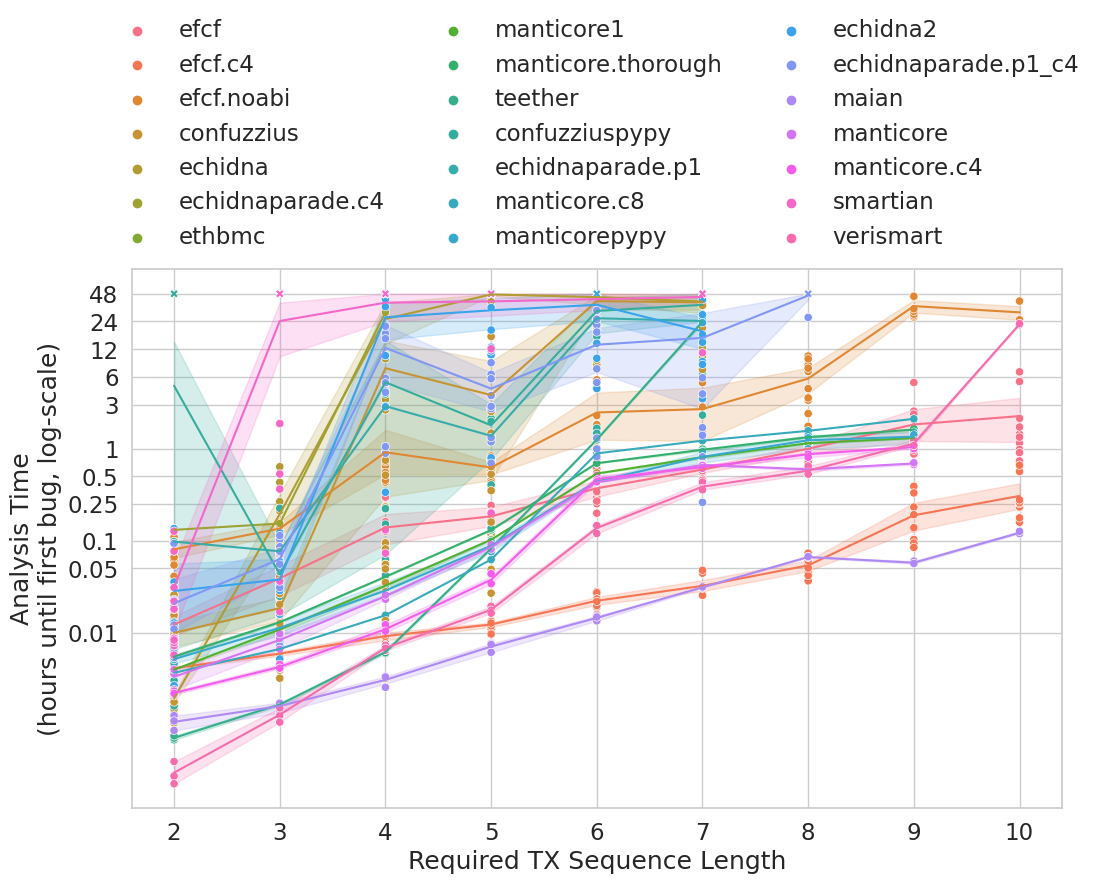

In [23]:
def make_multi_gen_plot(tools, figsize=(12,7), combined=combined, last_tick=48, colors=None, contract_type='multi_gen'):
    sns.set_style("whitegrid")
    #sns.color_palette("pastel")
    if colors:
        sns.set_palette(colors)
    else:
        sns.set_palette("colorblind")
    
    c = combined.copy()
    c.drop(c.index[c["contract"] != contract_type], inplace=True)
    
    for t in set(c['tool']):
        for l in set(c['txlength']):
            q = c[(c['tool'] == t) & (c['txlength'] == l)]
            foundbugs = (set(q['bugfound']))
            if foundbugs == {False}:
                c.drop(c.index[(c["tool"] == t) & (c['txlength'] == l)], inplace=True)
    
    c['runtime'] = c['runtime'].apply(lambda x: x / 60 / 60)
    if tools:
        c = c[c['tool'].isin(tools)]
#     c = c.sort_values('runtime')
    fig, ax = plt.subplots(figsize=figsize)
    
    ax = sns.lineplot(data = c,
                      hue = 'tool',
                      x = 'txlength',
                      y = 'runtime',
                      ax=ax,
                      legend=False)

    ax = sns.scatterplot(data = c,
                         hue = 'tool',
                         x = 'txlength',
                         y = 'runtime',
                         style = 'bugfound',
                         markers = {True: "o", False: "X"},
                         ax=ax)

    ax.set_yscale('log')
    ticks = [0.01, 0.05, 0.1, 0.25, 0.5, 1, 3, 6, 12, 24, 48]
    ticks = [tick for tick in ticks if tick <= last_tick]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)
    # fig.ax.set(ylim=(0,48))
    
    tick_spacing = 1
    ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator())

    ax.set_ylabel("Analysis Time\n(hours until first bug, log-scale)")
    ax.set_xlabel("Required TX Sequence Length")
    # fig.ax.set(xlim=(2,10))
    
    h,l = ax.get_legend_handles_labels()
    ax.legend(h[1:-3],l[1:-3])
    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, frameon=False,
    )
    
    return fig, ax


# This will plot all available data/tools; can become quite confusing.
fig, ax = make_multi_gen_plot(None)

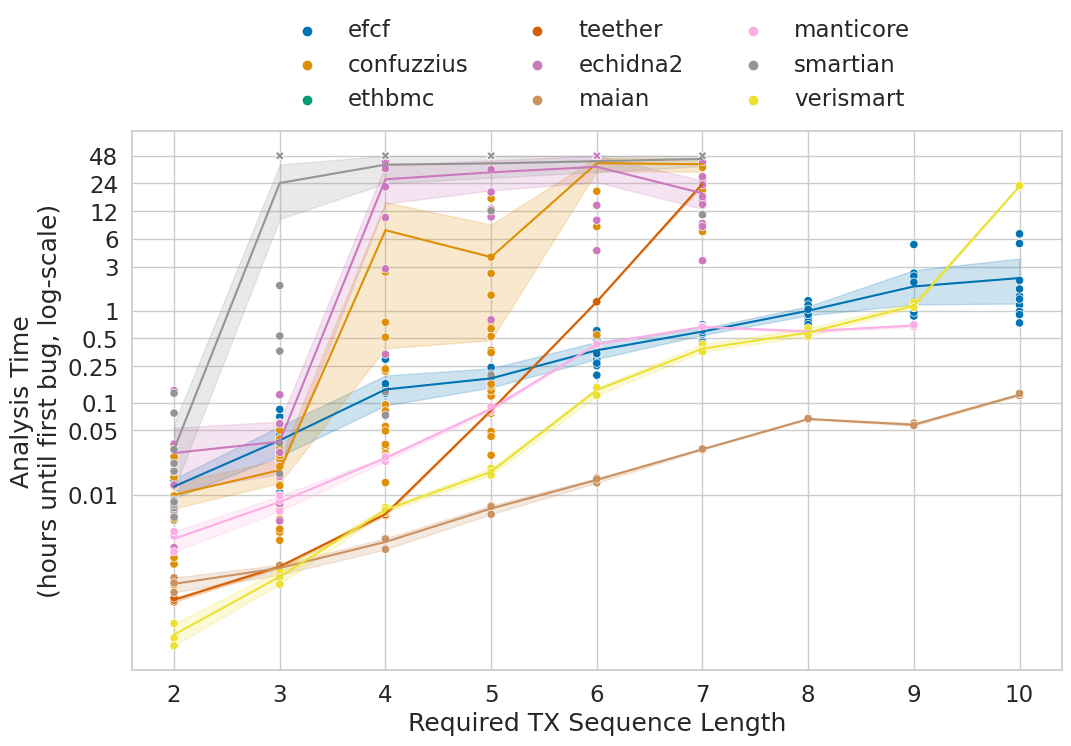

In [24]:
tools = set(combined['tool'])
tools.difference_update({'confuzziuspypy',
                                 'manticore.thorough', 
                                 'echidnaparade.p1',
                                 'echidnaparade.c4',
                                 'manticore1',
                                 'manticorepypy',
                                 'manticore.c8',
                                 'echidna',
                                 'manticore.c4',
                                 'echidnaparade.p1_c4',
                                 'efcf.c4',
                                 'efcf.noabi'
                                })
fig, ax = make_multi_gen_plot(sorted(list(tools)))

### Multi (Synthesized) Plots

In [25]:
# efcf, efcf.c4, teether, confuzzius, echidna2, echidnaparade, maian, manticore, mantic4, verismart
cpal = sns.color_palette("colorblind")
cc = list(cpal.as_hex())
cc = [cc[0], cc[-1], cc[2], cc[5], cc[1], cc[3], cc[-3], cc[4], cc[6], cc[-2]]
sns.color_palette(cc)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

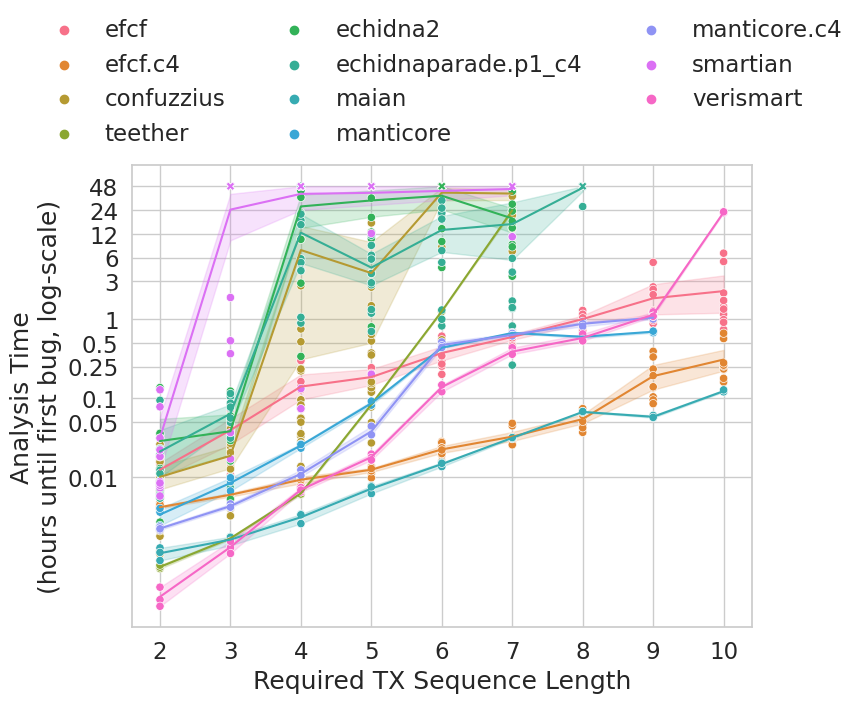

In [26]:
tools = {'efcf', 'efcf.c4', 'confuzzius', 'echidna2', 'echidnaparade.p1_c4', 
         'maian', 'manticore', 'manticore.c4', 'teether', 'verismart', 'smartian'}

fig, ax = make_multi_gen_plot(tools, figsize=(8,6), colors=cc)

In [27]:
cpal = sns.color_palette("colorblind")
cc = list(cpal.as_hex())
#     efcf, efcf.c4, teether, confuzzius, echidna2, maian, manticore, mantic4, verismart
cc = [cc[0], cc[-1], cc[2],    cc[5],       cc[1],  cc[-3], cc[4], cc[6], cc[-2]]
sns.color_palette(cc)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

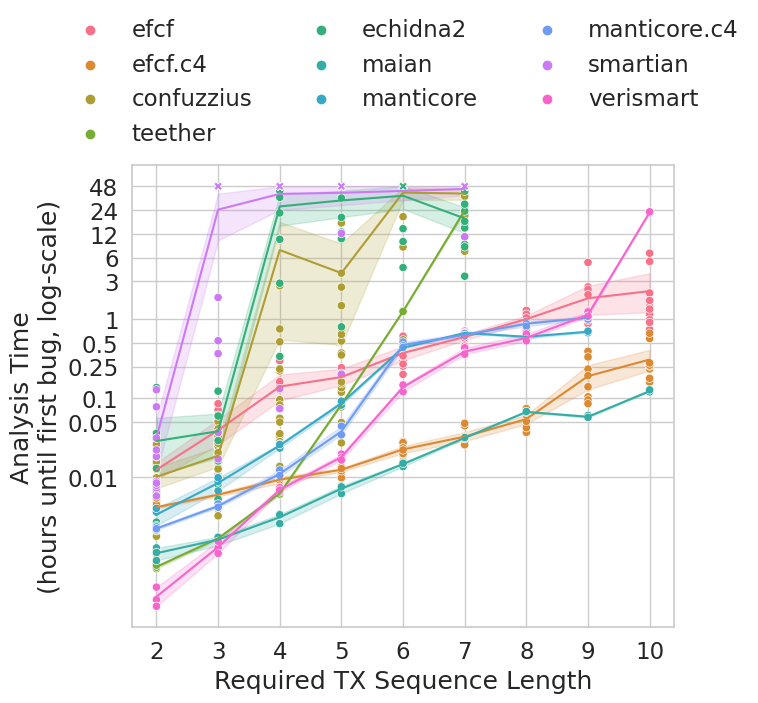

In [28]:
tools = {'efcf', 'efcf.c4', 'confuzzius', 'echidna2', 
         'maian', 'manticore', 'manticore.c4', 'teether', 'verismart', 'smartian'}

fig, ax = make_multi_gen_plot(tools, figsize=(7,6), colors=cc)

ax.get_figure().savefig("./multi_gen_lineplot.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_gen_lineplot.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_gen_lineplot.svg", bbox_inches='tight')

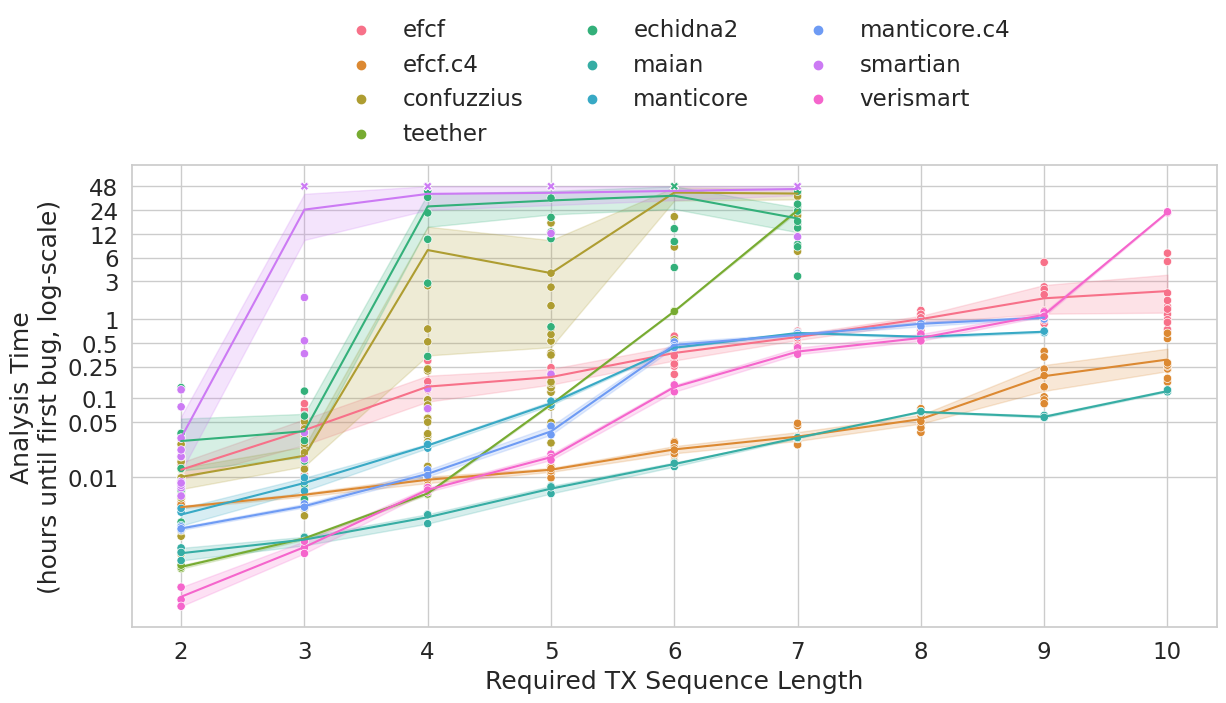

In [29]:
tools = {'efcf', 'efcf.c4', 'confuzzius', 'echidna2', 
         'maian', 'manticore', 'manticore.c4', 'teether', 'verismart', 'smartian'}

fig, ax = make_multi_gen_plot(tools, figsize=(14,6), colors=cc)

ax.get_figure().savefig("./multi_gen_lineplot.wide.pdf", bbox_inches='tight')

#### Comparison of EF/CF with tools using symbolic or concolic execution

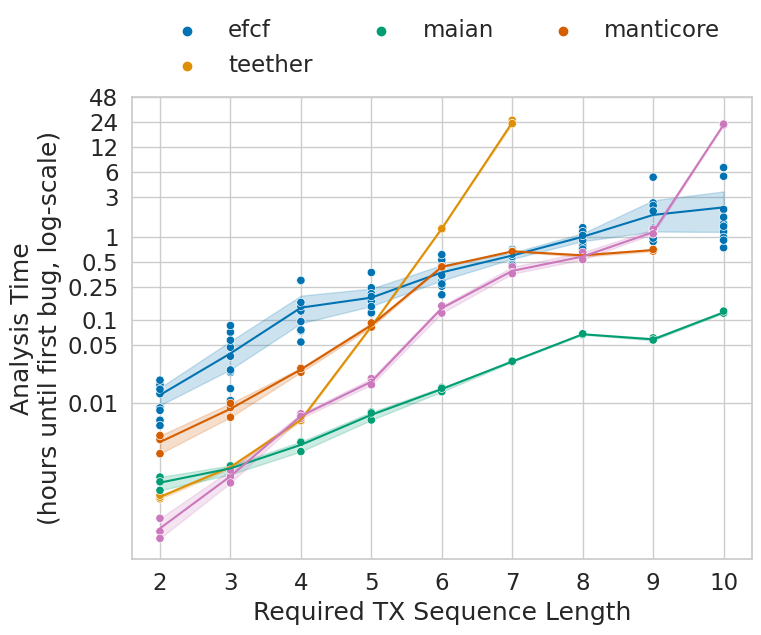

In [30]:
tools = {'efcf', 'maian', 'manticore', 'teether', 'verismart'}
fig, ax = make_multi_gen_plot(tools, figsize=(8,6), colors="colorblind")

#### Comparison of multi-core tools
difference between a single core and multi-core version of the same tool. Note: echidnaparade.p1 uses the echidna-parade wrapper script to run echidna on multiple cores, but without excluding any functions from the ABI, as 
would be the the normal mode of operation of echidna-parade.

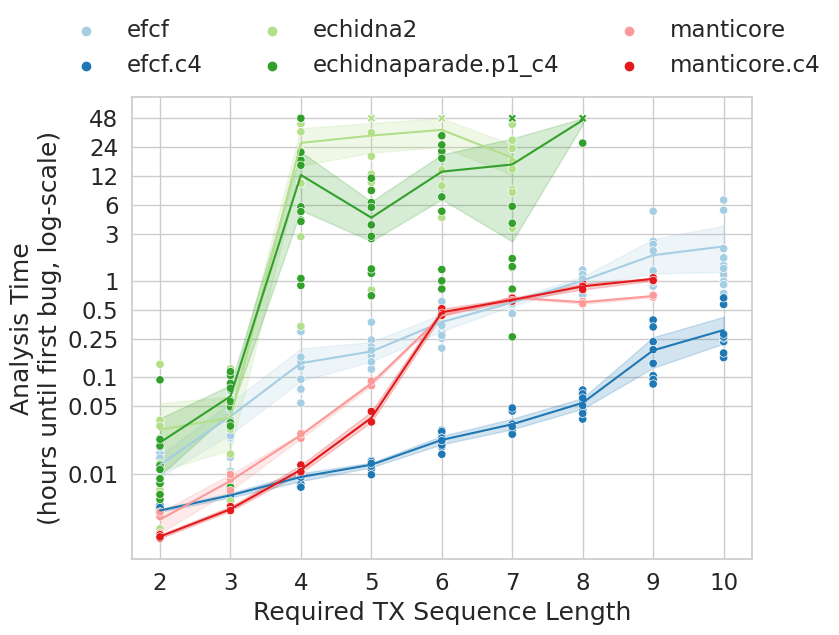

In [31]:
tools = {'efcf', 'efcf.c4', 'echidna2', 'echidnaparade.p1_c4', 'manticore', 'manticore.c4'}

fig, ax = make_multi_gen_plot(tools, figsize=(8,6), colors="Paired")

ax.get_figure().savefig("./multi_gen_lineplot_multicore.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_gen_lineplot_multicore.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_gen_lineplot_multicore.svg", bbox_inches='tight')

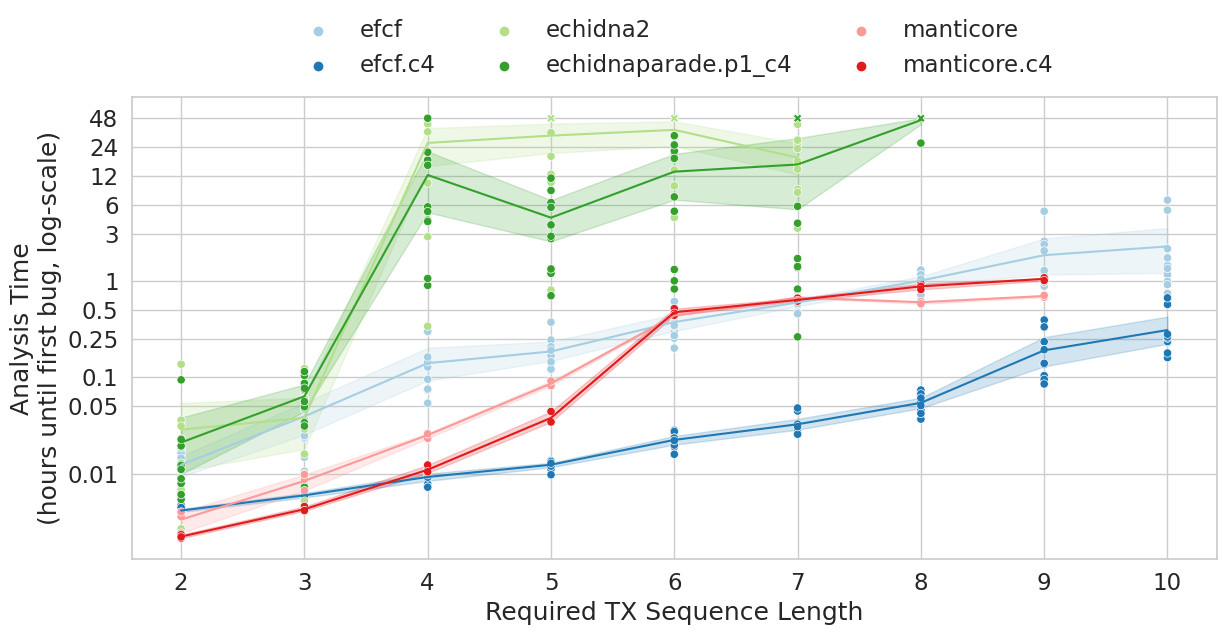

In [32]:
tools = {'efcf', 'efcf.c4', 'echidna2', 'echidnaparade.p1_c4', 'manticore', 'manticore.c4'}

fig, ax = make_multi_gen_plot(tools, figsize=(14,6), colors="Paired")

ax.get_figure().savefig("./multi_gen_lineplot_multicore.wide.pdf", bbox_inches='tight')

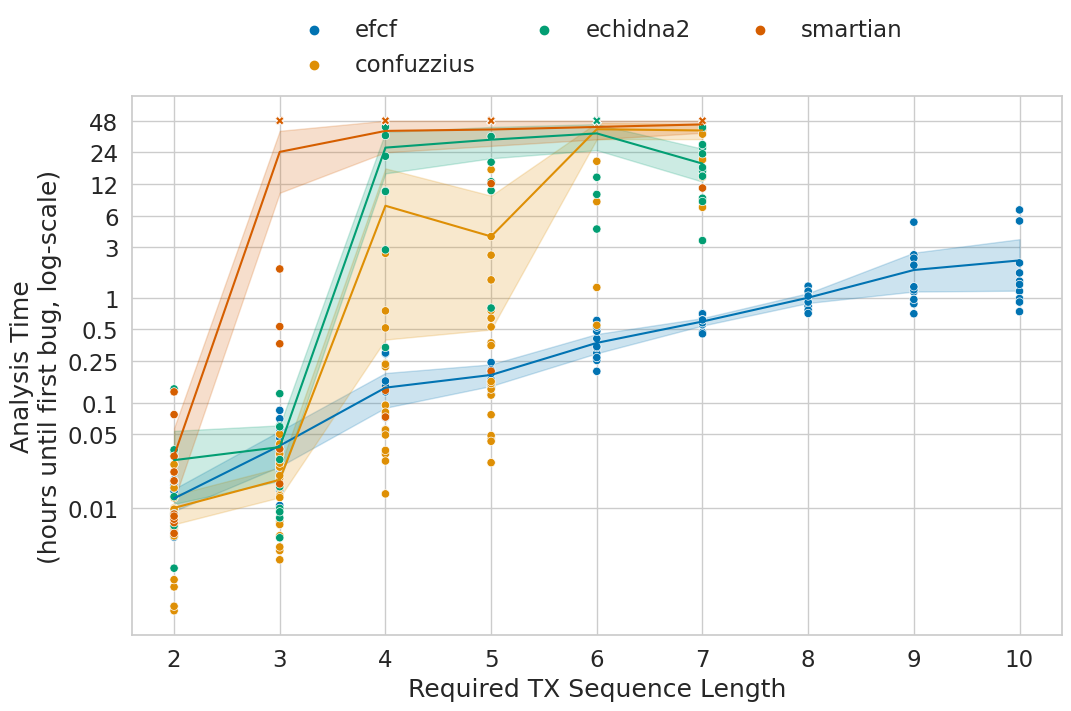

In [33]:
# Comparison of EF/CF to other fuzzers

tools = {'efcf', 'confuzzius', 
         'echidna2', 'smartian'}
fig, ax = make_multi_gen_plot(tools)

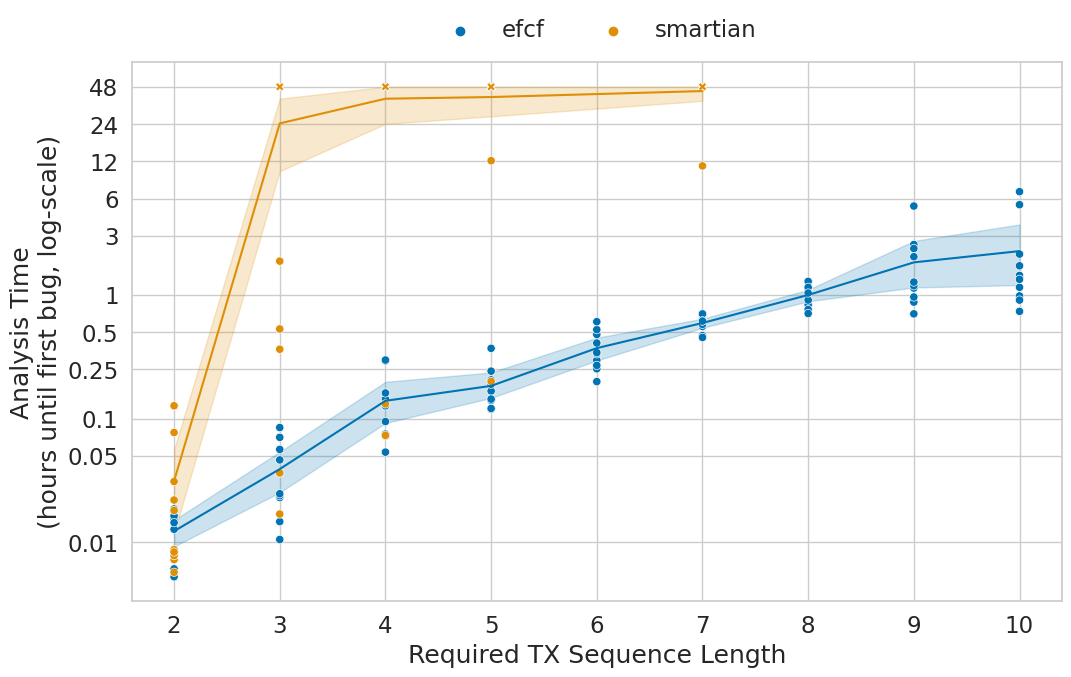

In [34]:
# Comparison of EF/CF to smartian

tools = {'efcf', 'smartian'}
fig, ax = make_multi_gen_plot(tools)

Interestingly, smartian sometimes identifies the bug in roughly the same timespan as EF/CF (up to TX length of 5). However, smartian seems to be incredibly unreliable. Most of the testcases simply time out for some reason. Even for moderately small contracts. Maybe smartian lacks some testcase/z3 timeout and gets stuck somewhere?

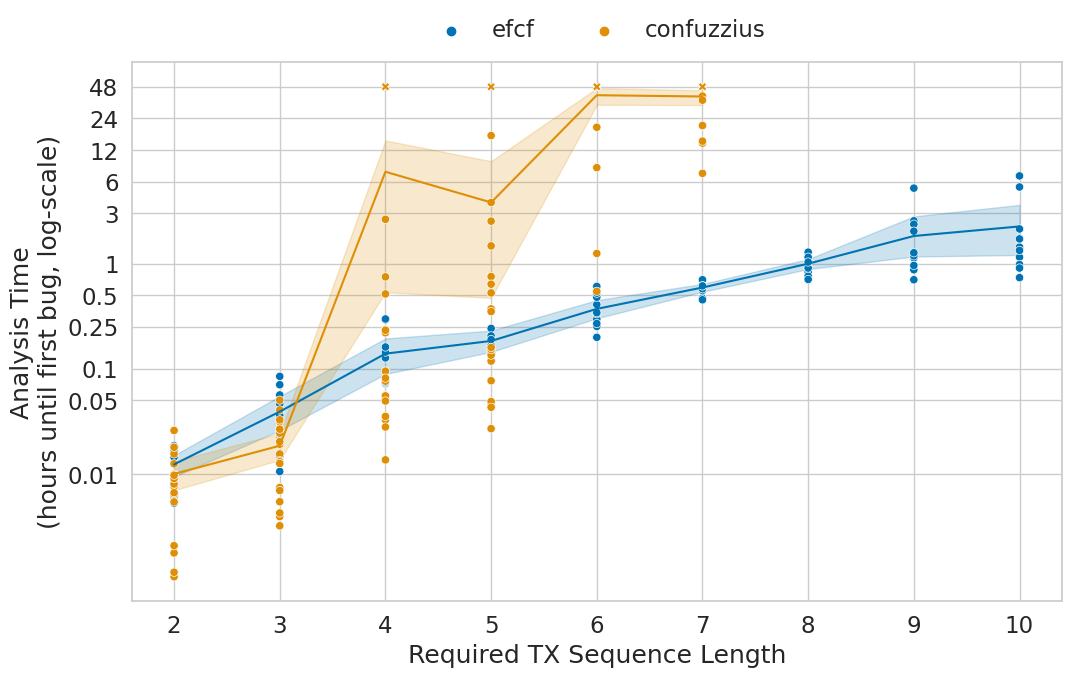

In [35]:
# Comparison of EF/CF to confuzzius

tools = {'efcf', 'confuzzius'}
fig, ax = make_multi_gen_plot(tools)

Confuzzius' success varies strongly. The median (and confidence interval) is far above the one of EF/CF, but until TX-length 5 we can see confuzzius producing quicker results. Since Confuzzius is using SMT-Solving to determine new mutations it can also solve the branch conditions in the generated multi benchmark.

We observed during manual experiments that Confuzzius seems to be highly influenced by the seed of the random number generator. This is probably due to the low testcase throughput.

In [36]:
# combined[(combined['tool'] == 'smartian') & (combined['contract'] == 'multi_gen')]

In [37]:
cpal = sns.color_palette("colorblind")
cc = list(cpal.as_hex())
#     efcf, efcf.c4, teether, confuzzius, echidna2, maian, manticore, mantic4, verismart
#cc = [cc[0], cc[1], cc[2],    cc[5],       cc[1],  cc[-3], cc[4], cc[6], cc[-2]]
# cc.pop(3)
# cc.pop(4)
cc.insert(1, cc.pop())
x = cc[2], cc[3]
cc[3], cc[2] = x
x = cc[4], cc[5]
cc[5], cc[4] = x
sns.color_palette(cc)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

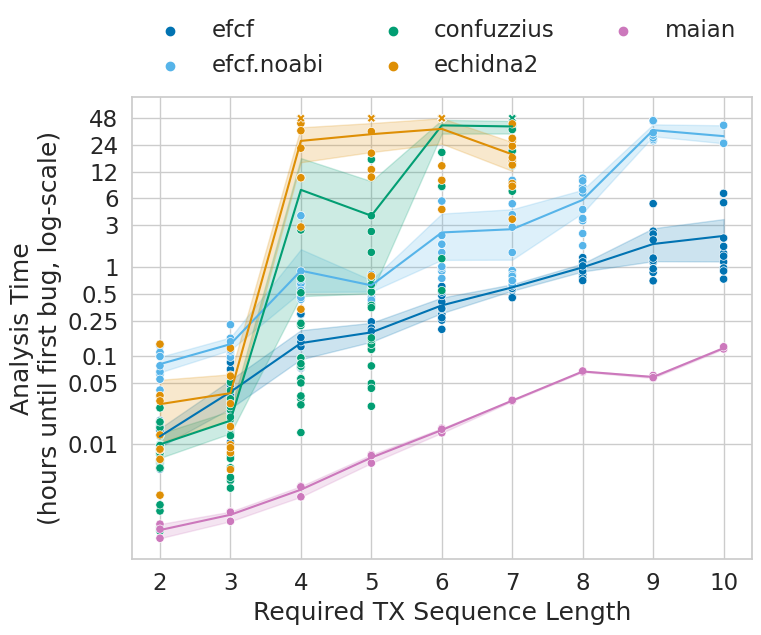

In [38]:
# Comparison of EF/CF with and without ABI to selected other tools 
# (fuzzers with ABI, and best symex without ABI)

tools = {'efcf', 'efcf.noabi', 'echidna2', 'confuzzius', 'maian'}
fig, ax = make_multi_gen_plot(tools, figsize=(8,6), colors=cc)

ax.get_figure().savefig("./multi_gen_lineplot_noabi.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_gen_lineplot_noabi.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_gen_lineplot_noabi.svg", bbox_inches='tight')

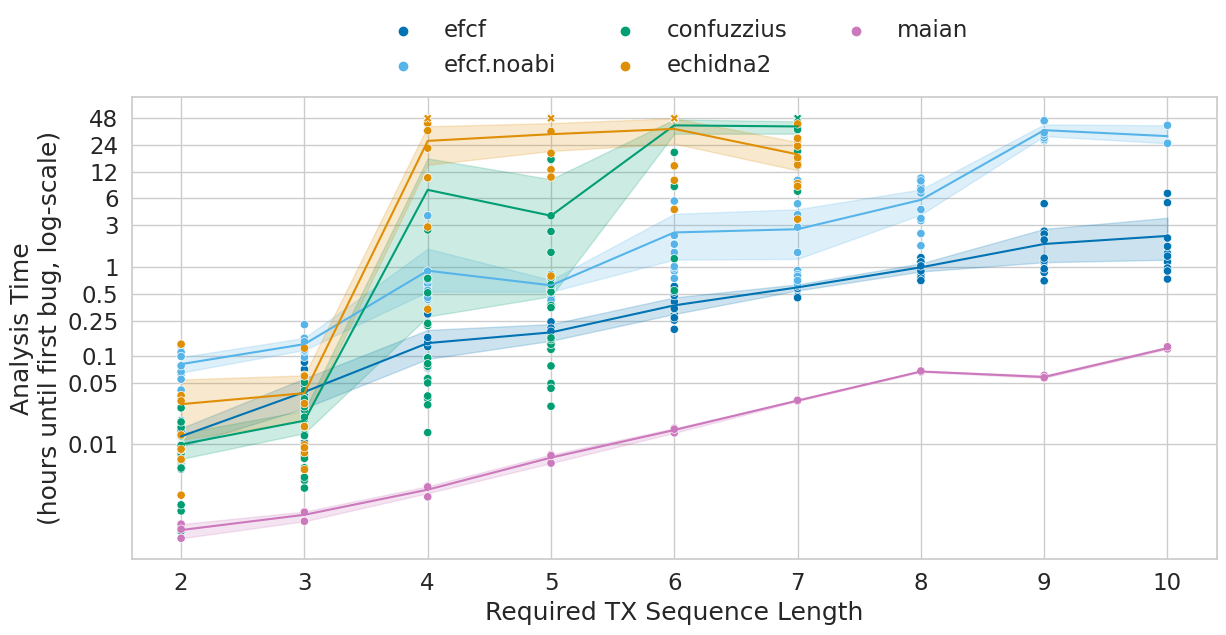

In [39]:
tools = {'efcf', 'efcf.noabi', 'echidna2', 'confuzzius', 'maian'}
fig, ax = make_multi_gen_plot(tools, figsize=(14,6), colors=cc)

ax.get_figure().savefig("./multi_gen_lineplot_noabi.wide.pdf", bbox_inches='tight')

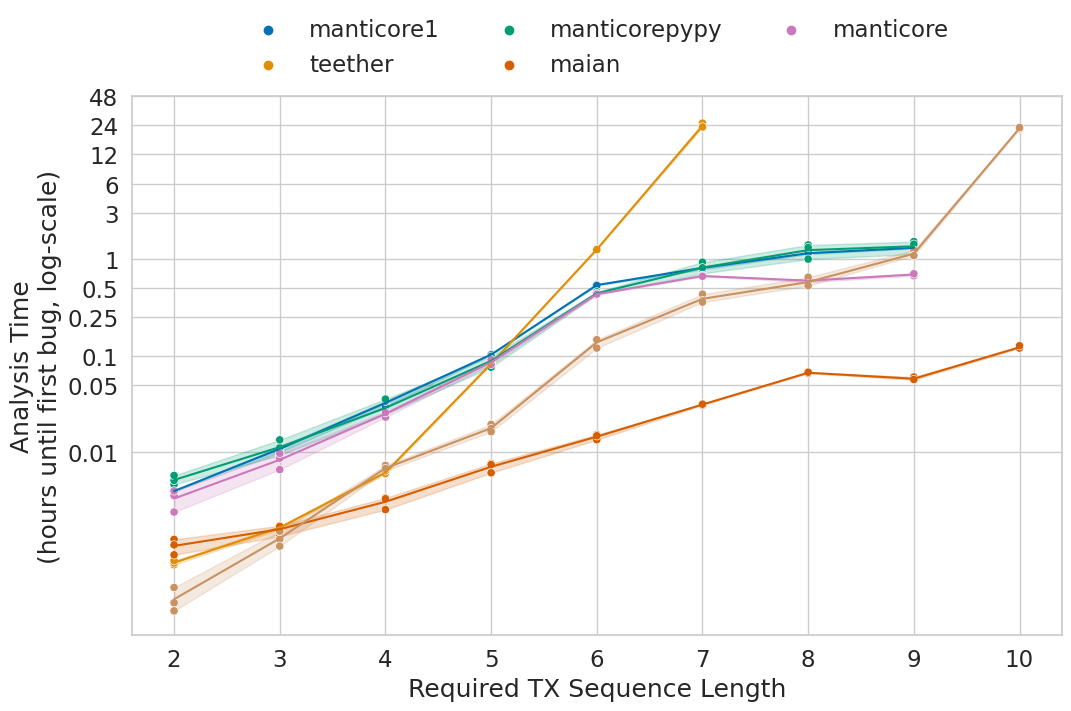

In [40]:
# Comparison of symbolic execution tools

tools = {'maian', 'teether', 'manticore', 'manticore1', 'manticorepypy', 'verismart'}
fig, ax = make_multi_gen_plot(tools)

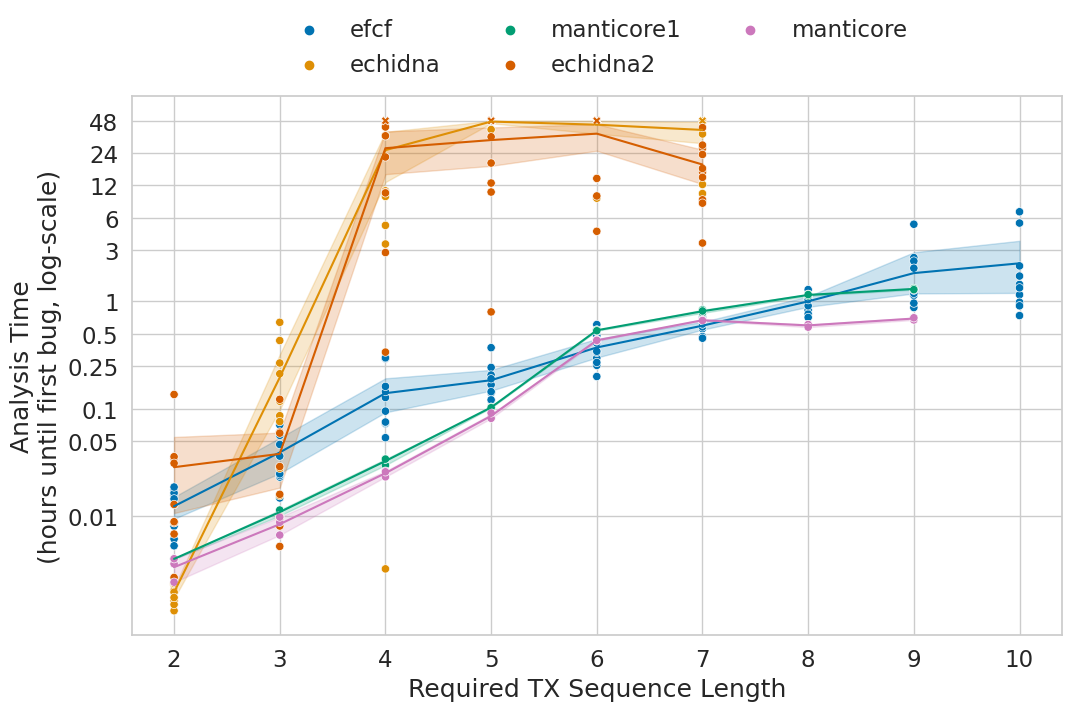

In [41]:
# Comparison of EF/CF with industry tools

tools = {'efcf', 'manticore', 'manticore1', 'echidna', 'echidna2'}
fig, ax = make_multi_gen_plot(tools)

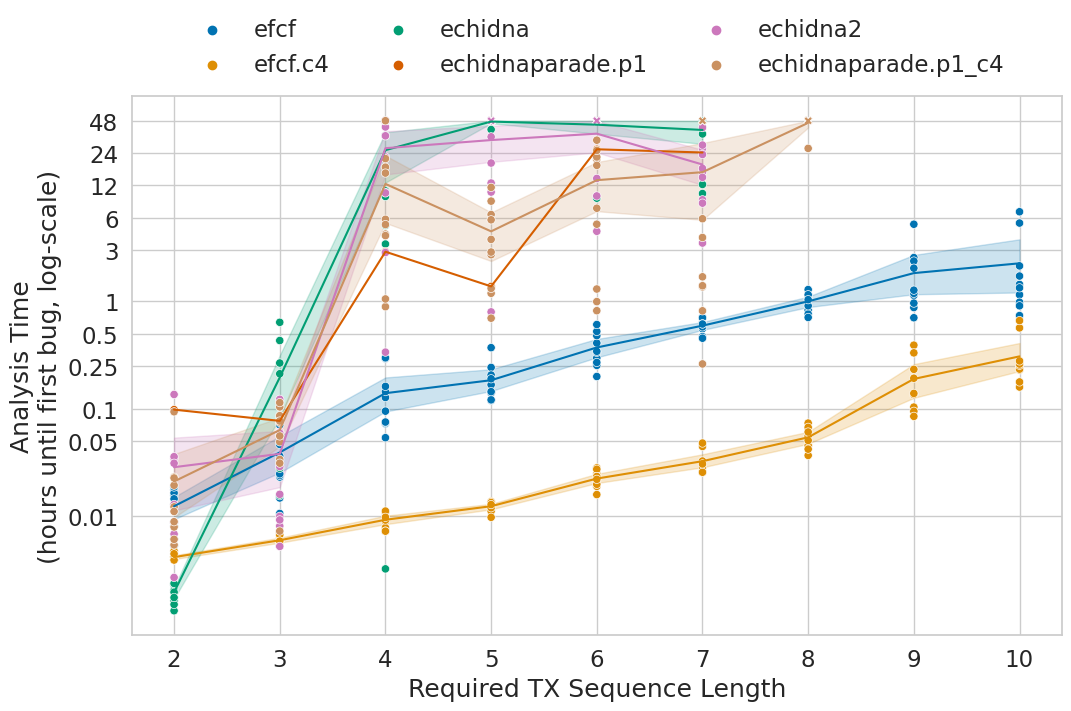

In [42]:
# Comparison of EF/CF with echidna

tools = {'efcf', 'efcf.c4', 'echidna', 'echidna2', 'echidnaparade.p1', 'echidnaparade.p1_c4'}
fig, ax = make_multi_gen_plot(tools)

Text(0.5, 0, 'Required TX Sequence Length')

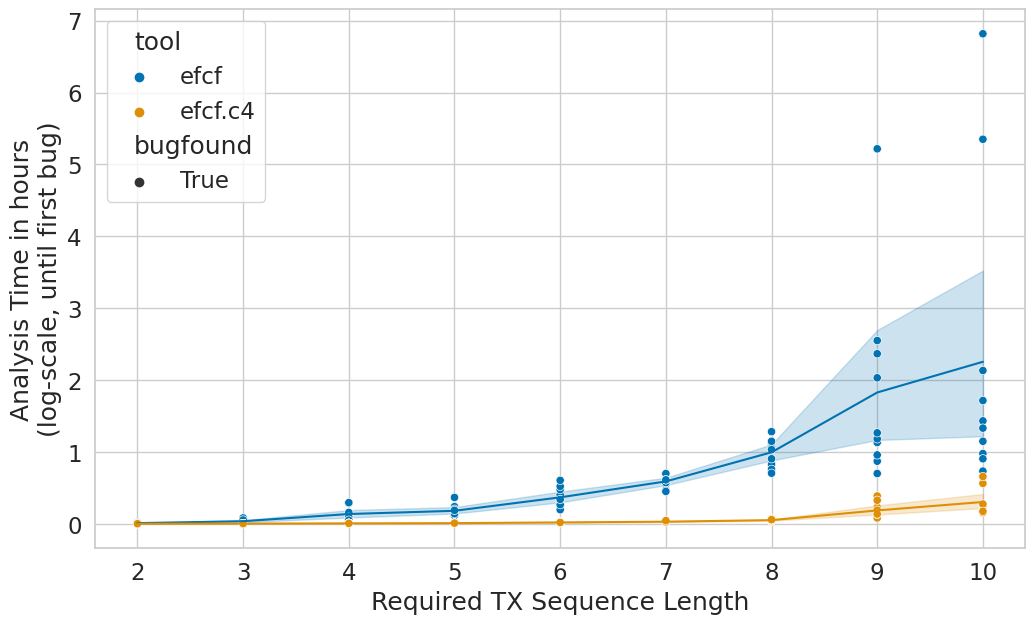

In [43]:
c = combined.copy()
# c['txlength'] = c['txlength'].map(lambda x: x + 1)
# c = c.drop(c.index[c["tool"] == 'ethbmc'])
c.drop(c.index[c["contract"] != 'multi_gen'], inplace=True)

c['runtime'] = c['runtime'].apply(lambda x: x / 60 / 60)

c = c[c['tool'].isin(('efcf', 'efcf.c4', 'efcf.c8'))]

fig, ax = plt.subplots(figsize=(12,7))
# sns.set(rc={"figure.figsize":(20, 10)})
sns.set_style("whitegrid")
sns.set_palette("colorblind")


ax = sns.lineplot(data = c,
                  hue = 'tool',
                  x = 'txlength',
                  y = 'runtime',
                  ax=ax,
                  legend=False)

ax = sns.scatterplot(data = c,
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime',
                     style = 'bugfound',
                     markers = {True: "o", False: "X"},
                     ax=ax)

# ax.set_yscale('log')
# ticks = [0.01, 0.25, 0.5, 1, 3, 6, 12, 24, 48]
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks)
# fig.ax.set(ylim=(0,48))

ax.set_ylabel("Analysis Time in hours\n(log-scale, until first bug)")
ax.set_xlabel("Required TX Sequence Length")
# fig.ax.set(xlim=(2,10))

In [44]:
combined[(combined['bugfound']) & (combined['contract'] == 'multi_man_complex')]

tool       runtime           contract  txlength  bugfound
130        efcf    343.000000  multi_man_complex         5      True
131        efcf    624.000000  multi_man_complex         5      True
132        efcf    235.000000  multi_man_complex         5      True
133        efcf    611.000000  multi_man_complex         5      True
134        efcf    603.000000  multi_man_complex         5      True
...         ...           ...                ...       ...       ...
2324  verismart    777.678121  multi_man_complex         5      True
2325  verismart    775.015416  multi_man_complex         5      True
2326  verismart  24962.987023  multi_man_complex         7      True
2327  verismart  24002.756891  multi_man_complex         7      True
2328  verismart  24332.879938  multi_man_complex         7      True

[106 rows x 5 columns]

### Multi (Complex, Manual) Plots

Text(0.5, 0, 'Required TX Sequence Length')

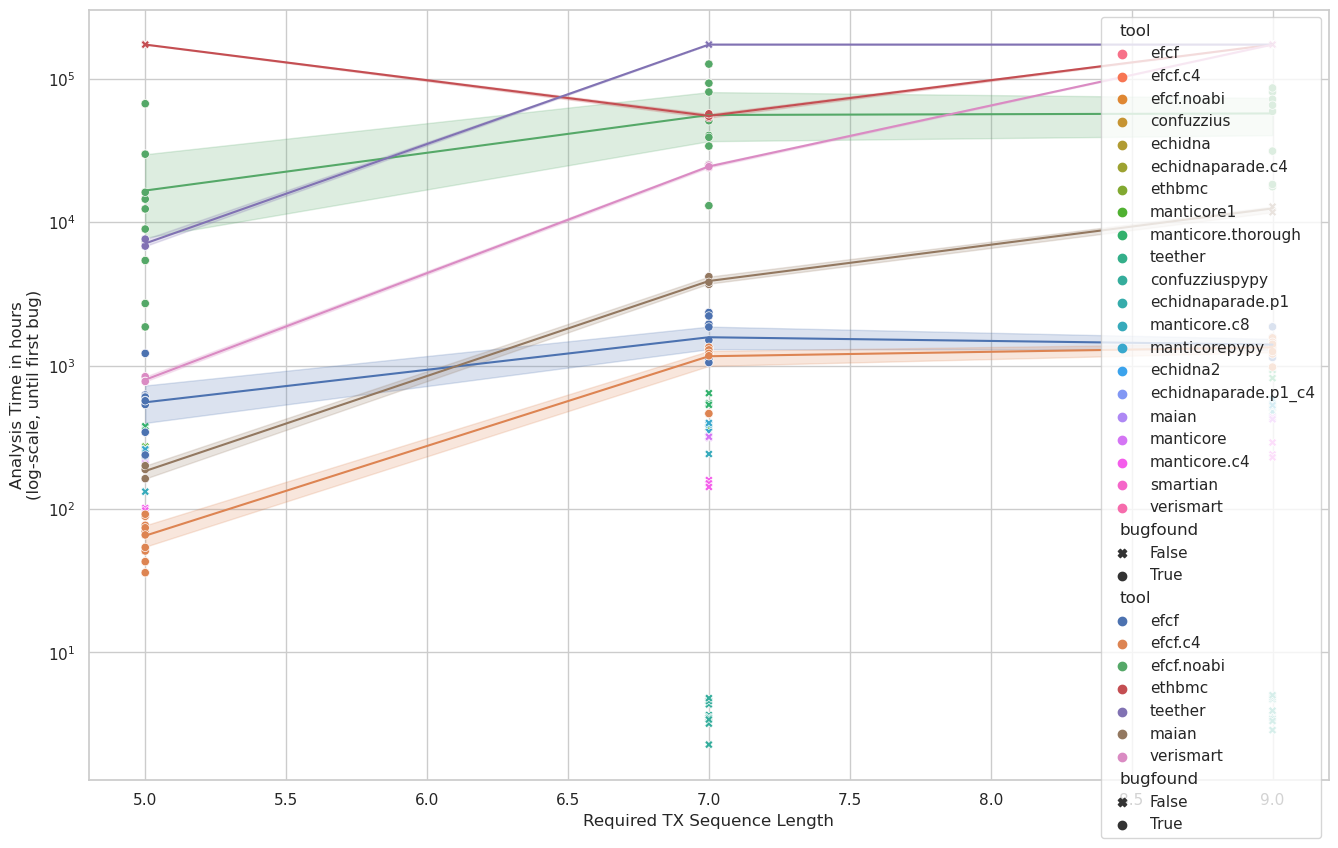

In [45]:
#fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(16, 10)})
sns.set_style("whitegrid")

c = combined.copy()
c.drop(c.index[c["contract"] != 'multi_man_complex'], inplace=True)
# c.drop(c.index[c["bugfound"] != True], inplace=True)
# c.drop(c.index[(c["bugfound"] != True) & (c['tool'] != 'efcf')], inplace=True)

capable_tools = set()
for tool in set(c['tool']):
    if sum(c[c['tool'] == tool]['bugfound']) > 0:
        capable_tools.add(tool)

ax = sns.scatterplot(data = c,
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime',
#                    dodge=True,
#                    legend=False,
                     style = 'bugfound',
                     markers = {True: "o", False: "X"},
                     )

# c['runtime'] = c['runtime'].apply(lambda x: x / 60 / 60)


c = c[c['tool'].isin(capable_tools)]

ax = sns.lineplot(data = c,
                  hue = 'tool',
                  x = 'txlength',
                  y = 'runtime',
                  ax=ax,
                  legend=False)

ax = sns.scatterplot(data = c,
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime',
                     style = 'bugfound',
                     markers = {True: "o", False: "X"},
                     ax=ax)

ax.set_yscale('log')
# ticks = [0.01, 0.25, 0.5, 1, 3, 6, 12, 24, 48]
# ax.set_yticks(ticks)
# ax.set_yticklabels(ticks)
# fig.ax.set(ylim=(0,48))

ax.set_ylabel("Analysis Time in hours\n(log-scale, until first bug)")
ax.set_xlabel("Required TX Sequence Length")
# fig.ax.set(xlim=(2,10))

Text(0.5, 0, 'Required TX Sequence Length')

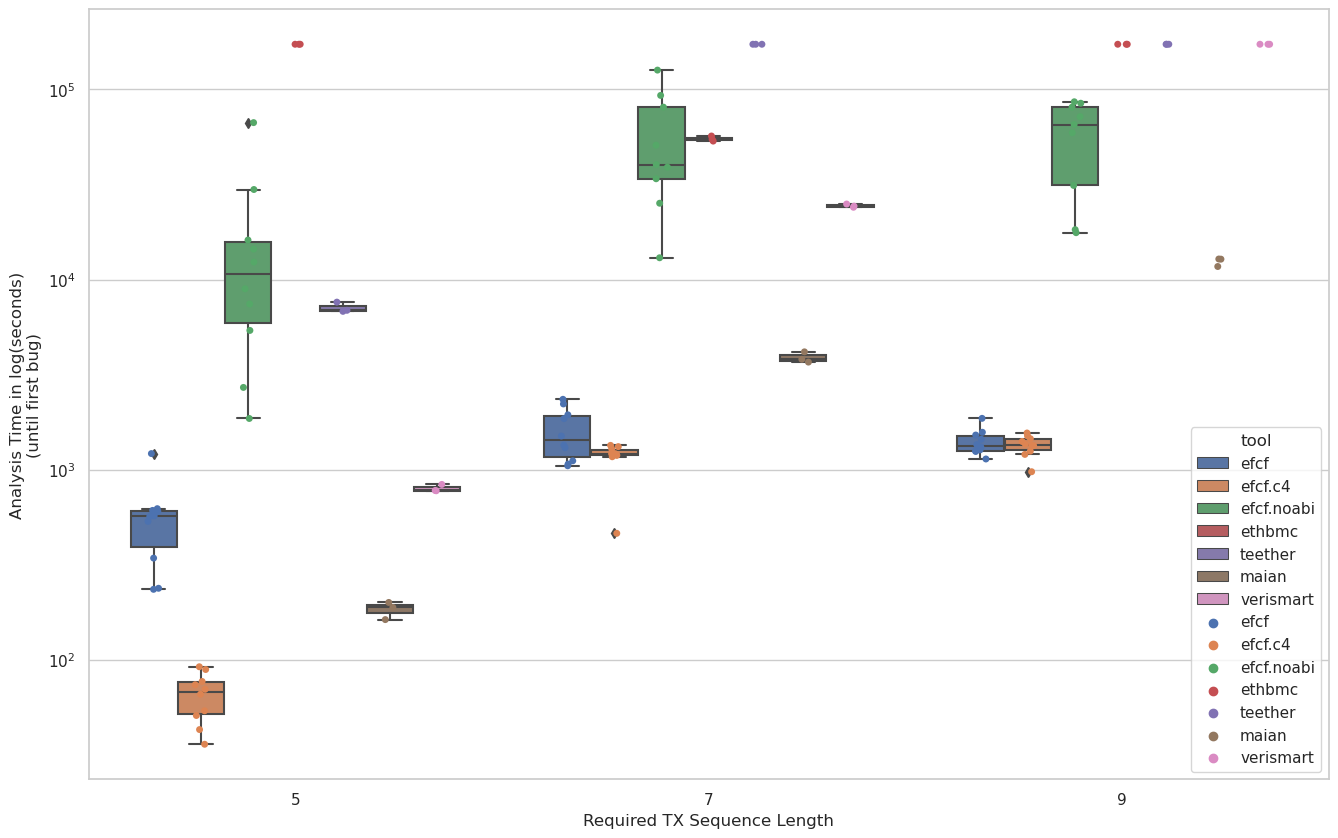

In [46]:
#fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(16, 10)})
sns.set_style("whitegrid")

c = combined.copy()
c.drop(c.index[c["contract"] != 'multi_man_complex'], inplace=True)
# c.drop(c.index[c["bugfound"] != True], inplace=True)
# c.drop(c.index[(c["bugfound"] != True) & (c['tool'] != 'efcf')], inplace=True)

capable_tools = set()
for tool in set(c['tool']):
    if sum(c[c['tool'] == tool]['bugfound']) > 0:
        capable_tools.add(tool)
        
c = c[c['tool'].isin(capable_tools)]
        
# data = c[c['tool'].isin(capable_tools)]

# c.drop(c.index[c["contract"] != 'multi_man_complex'], inplace=True)
ax = sns.boxplot(data = c[c['bugfound'] == True],
                 hue = 'tool',
                 x = 'txlength',
                 y = 'runtime')

ax = sns.stripplot(data = c[c['tool'].isin(capable_tools)],
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime',
                   dodge=True,
#                    legend=False,
#                      style = 'bugfound',
#                      markers = {True: "o", False: "X"},
                     ax=ax)

ax.set_yscale('log')
ax.set_ylabel("Analysis Time in log(seconds)\n(until first bug)")
ax.set_xlabel("Required TX Sequence Length")

# ax.get_figure().savefig("./multi_max_complex_boxplot.pdf", bbox_inches='tight')
# ax.get_figure().savefig("./multi_max_complex_boxplot.png", bbox_inches='tight')
# ax.get_figure().savefig("./multi_max_complex_boxplot.svg", bbox_inches='tight')

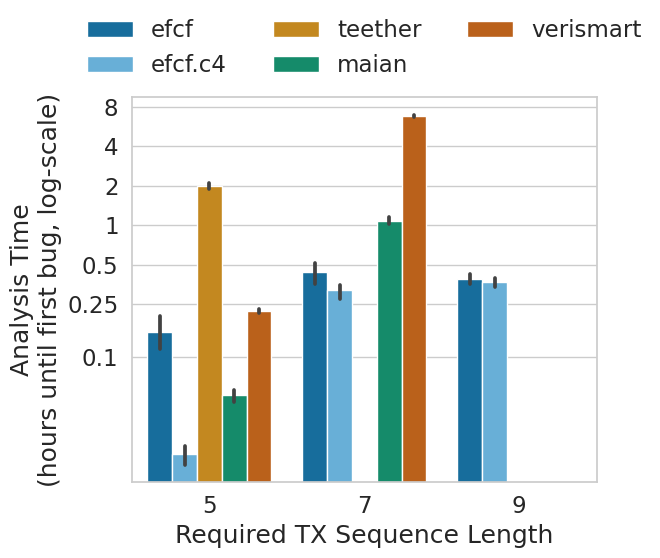

In [47]:
def make_multi_complex_plot(tools=None, figsize=(6,5), combined=combined, last_tick=48, colors=None, contract_type='multi_man_complex'):

    c = combined.copy()

    c.drop(c.index[c["contract"] != contract_type], inplace=True)

    capable_tools = set()
    for tool in set(c['tool']):
        if sum(c[c['tool'] == tool]['bugfound']) > 0:
            capable_tools.add(tool)
    # capable_tools.add('smartian')

    c['runtime'] = c['runtime'].apply(lambda x: x / 60 / 60)

    c = c[c['tool'].isin(capable_tools)]

    c = c[c['tool'] != 'efcf.c8']
    c = c[c['tool'] != 'efcf.noabi']
    c = c[c['tool'] != 'ethbmc']

    c = c[c['bugfound'] == True]


    sns.set_context("paper")
    sns.set(font_scale=1.5)
    # sns.set_palette("Paired")

    colors = sns.color_palette("colorblind")
    colors.insert(1, colors.pop())
    sns.set_palette(colors)

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    b = sns.barplot(data = c,
                    hue = 'tool',
                    x = 'txlength',
                    y = 'runtime',
                    ax=ax)

    # s = sns.scatterplot(data = c,
    #                      hue = 'tool',
    #                      x = 'txlength',
    #                      y = 'runtime',
    #                      style = 'bugfound',
    #                      markers = {True: "o", False: "X"},
    #                      ax=ax)

    ax.set_yscale('log')
    # fig.ax.set(ylim=(0,48))
    ticks = [0.1, 0.25, 0.5, 1, 2, 4, 8] #10,24,48]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    ax.set_ylabel("Analysis Time\n(hours until first bug, log-scale)")
    ax.set_xlabel("Required TX Sequence Length")
    # fig.ax.set(xlim=(2,10))

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    return (fig, ax)

fig, ax = make_multi_complex_plot()
ax.get_figure().savefig("./multi_man.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_man.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_man.svg", bbox_inches='tight')

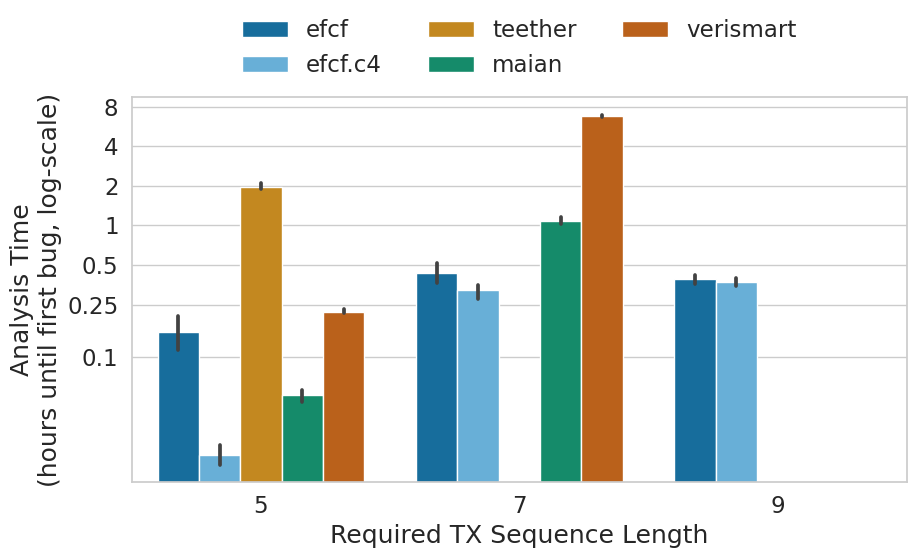

In [48]:
fig, ax = make_multi_complex_plot(figsize=(10,5))
ax.get_figure().savefig("./multi_man.wide.pdf", bbox_inches='tight')

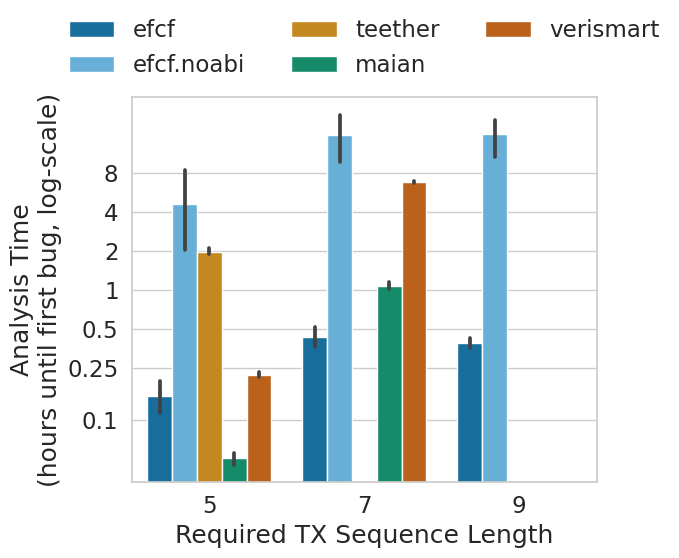

In [49]:
def make_multi_complex_noabi_plot(tools=None, figsize=(6,5), combined=combined, last_tick=48, colors=None):
    c = combined.copy()

    c.drop(c.index[c["contract"] != 'multi_man_complex'], inplace=True)

    capable_tools = set()
    for tool in set(c['tool']):
        if sum(c[c['tool'] == tool]['bugfound']) > 0:
            capable_tools.add(tool)
    capable_tools.add('smartian')

    c['runtime'] = c['runtime'].apply(lambda x: x / 60 / 60)

    c = c[c['tool'].isin(capable_tools)]

    c = c[c['tool'] != 'efcf.c8']
    c = c[c['tool'] != 'efcf.c4']
    c = c[c['tool'] != 'ethbmc']

    c = c[c['bugfound'] == True]


    sns.set_context("paper")
    sns.set(font_scale=1.5)
    # sns.set_palette("Paired")

    colors = sns.color_palette("colorblind")
    colors.insert(1, colors.pop())
    sns.set_palette(colors)

    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    b = sns.barplot(data = c,
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime',
                   ax=ax)

    # s = sns.scatterplot(data = c,
    #                      hue = 'tool',
    #                      x = 'txlength',
    #                      y = 'runtime',
    #                      style = 'bugfound',
    #                      markers = {True: "o", False: "X"},
    #                      ax=ax)

    ax.set_yscale('log')
    # fig.ax.set(ylim=(0,48))
    ticks = [0.1, 0.25, 0.5, 1, 2, 4, 8] #10,24,48]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    ax.set_ylabel("Analysis Time\n(hours until first bug, log-scale)")
    ax.set_xlabel("Required TX Sequence Length")
    # fig.ax.set(xlim=(2,10))

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    return (fig, ax)

fig, ax = make_multi_complex_noabi_plot()
ax.get_figure().savefig("./multi_man_noabi.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_man_noabi.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_man_noabi.svg", bbox_inches='tight')

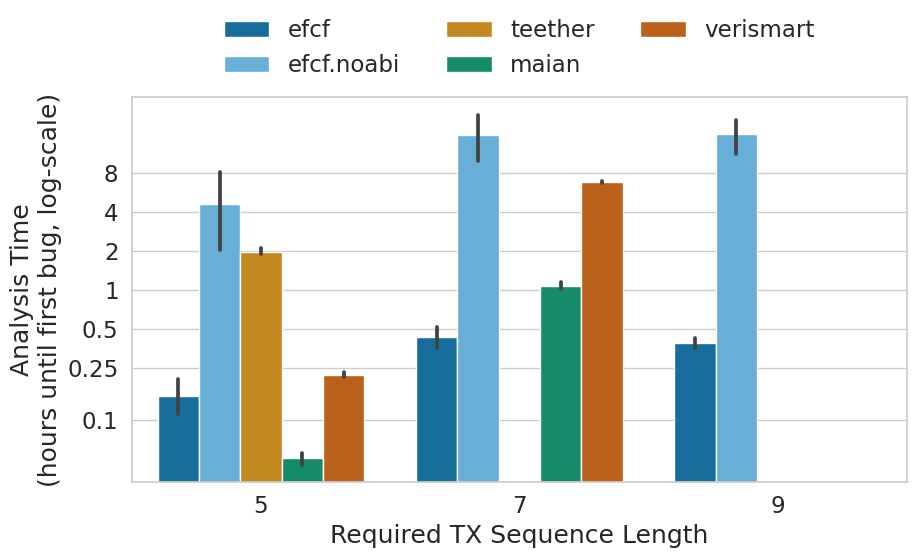

In [50]:
fig, ax = make_multi_complex_noabi_plot(figsize=(10,5))
ax.get_figure().savefig("./multi_man_noabi.wide.pdf", bbox_inches='tight')

### Justlen Plots

The justlen benchmark contract is adapted from the [echidna-parade example](https://github.com/crytic/echidna-parade/blob/main/examples/justlen.sol)

Text(0.5, 0, 'Required Array Length')

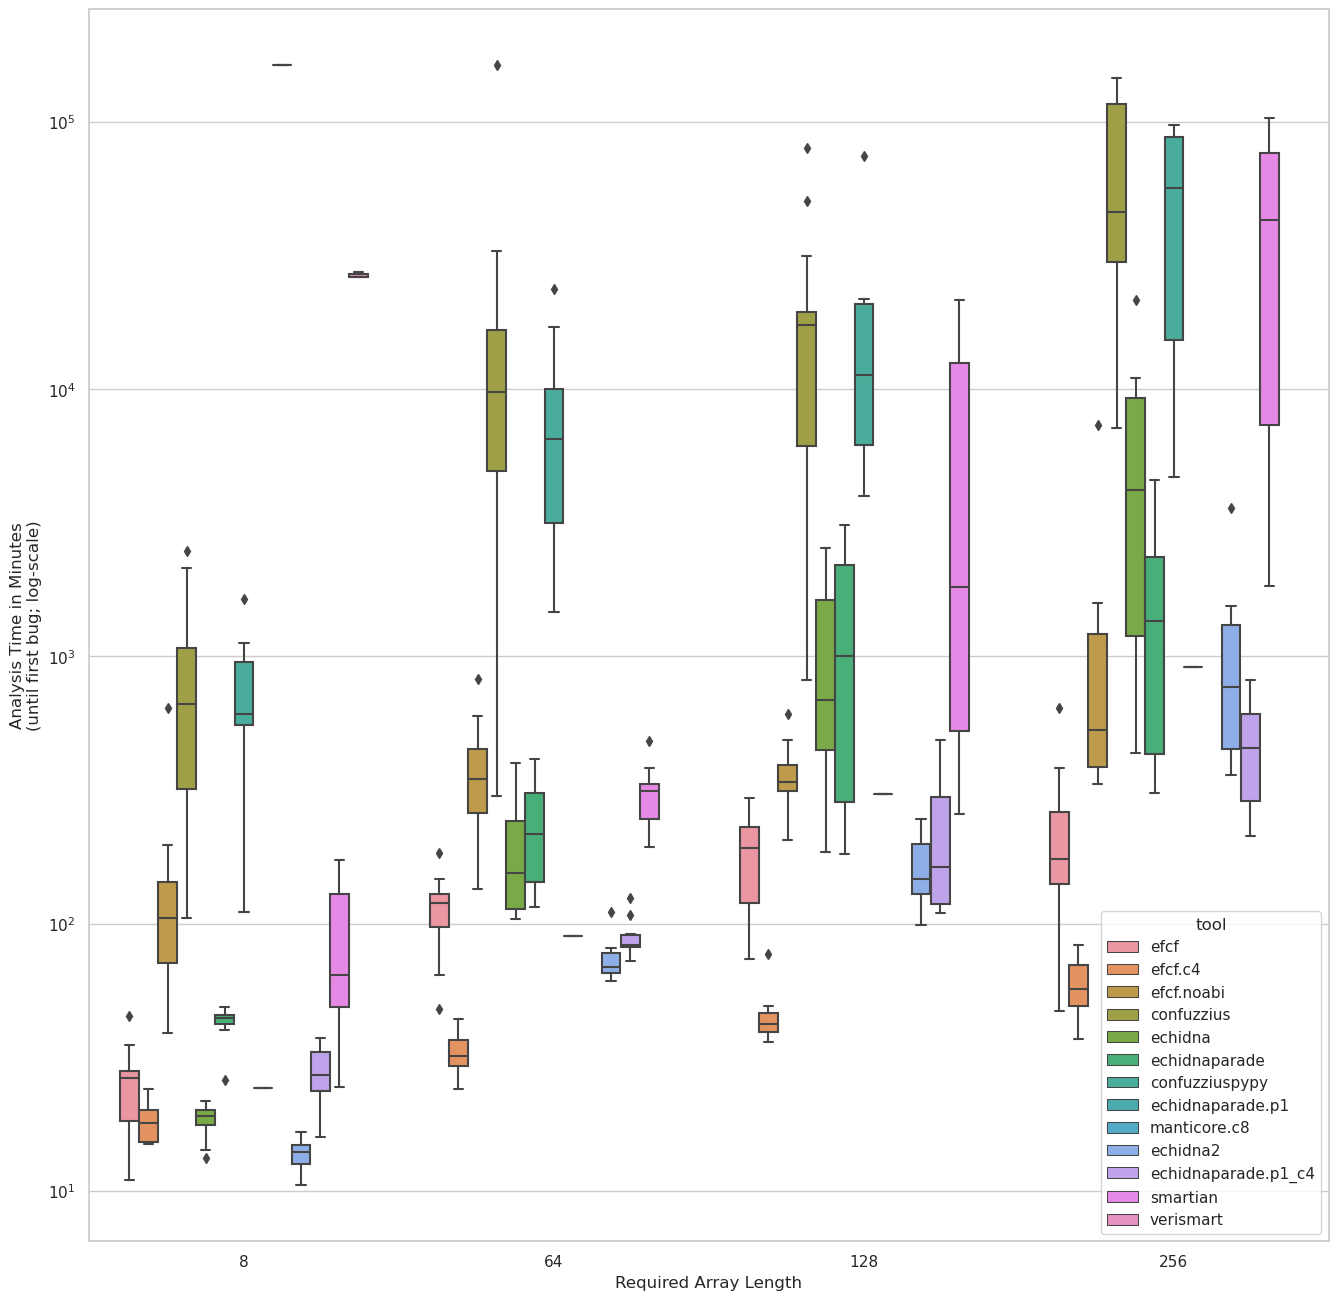

In [51]:
#fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(16, 16)})
sns.set_style("whitegrid")
c = combined.copy()
c.drop(c.index[c["contract"] != 'justlen'], inplace=True)
c.drop(c.index[c["bugfound"] != True], inplace=True)

c.drop(c.index[c["tool"] == 'manticore.c4'], inplace=True)
c.drop(c.index[c["tool"] == 'manticore.thorough'], inplace=True)
c.drop(c.index[c["tool"] == 'echidnaparade.c4'], inplace=True)
c.drop(c.index[c["tool"] == 'maian'], inplace=True)
c.drop(c.index[c["tool"] == 'ethbmc'], inplace=True)

ax = sns.boxplot(data = c,
                 hue = 'tool', # different colors for different 'cls'
                 x = 'txlength',
                 y = 'runtime')
ax.set_yscale('log')
ax.set_ylabel("Analysis Time in Minutes\n(until first bug; log-scale)")
ax.set_xlabel("Required Array Length")

# ax.get_figure().savefig("./justlen.pdf", bbox_inches='tight')
# ax.get_figure().savefig("./justlen.png", bbox_inches='tight')


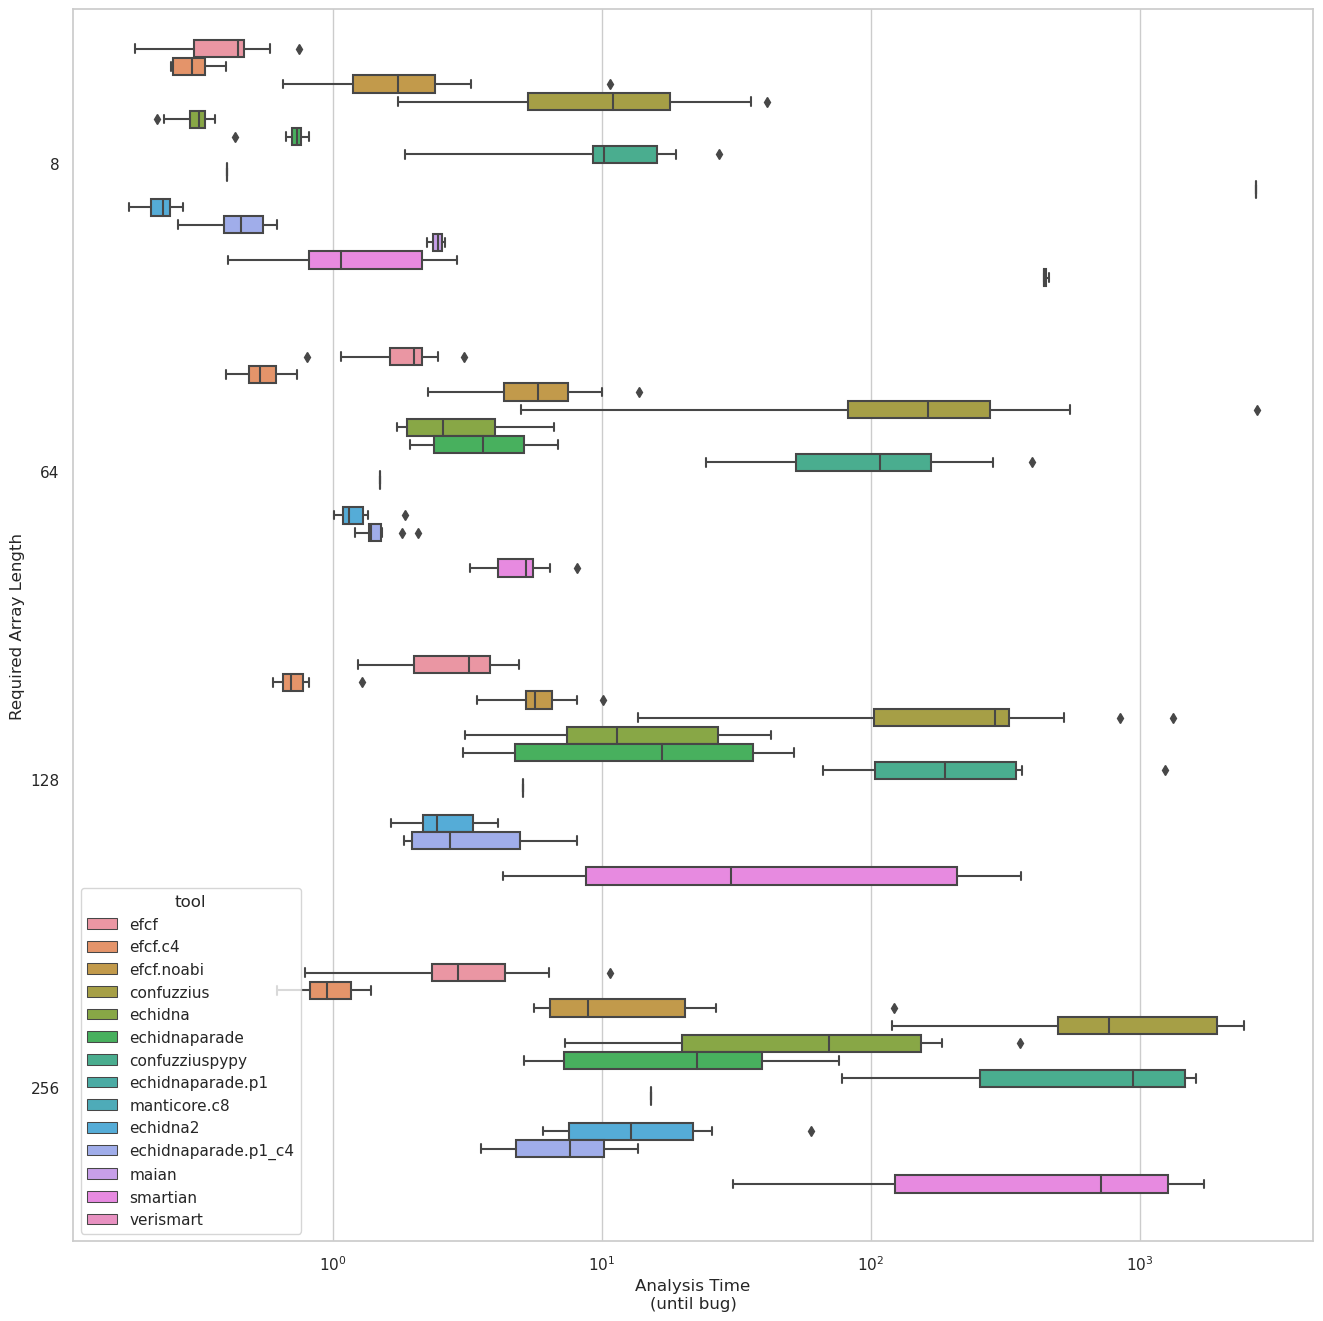

In [52]:
#fig, ax = plt.subplots()
sns.set(rc={"figure.figsize":(16, 16)})
sns.set_style("whitegrid")
c = combined.copy()
c.drop(c.index[c["contract"] != 'justlen'], inplace=True)

c.drop(c.index[c["bugfound"] != True], inplace=True)

c.drop(c.index[c["tool"] == 'manticore.c4'], inplace=True)
c.drop(c.index[c["tool"] == 'manticore.thorough'], inplace=True)
c.drop(c.index[c["tool"] == 'echidnaparade.c4'], inplace=True)
c.drop(c.index[c["tool"] == "ethbmc"], inplace=True)


c['runtime'] = c['runtime'].apply(lambda x: x / 60)


ax = sns.boxplot(data = c,
                 hue = 'tool', # different colors for different 'cls'
                 y = 'txlength',
                 x = 'runtime', orient='h')
ax.set_xscale('log')
ax.set_xlabel("Analysis Time\n(until bug)")
ax.set_ylabel("Required Array Length")

# ax.get_figure().savefig("./justlen.pdf")
# ax.get_figure().savefig("./justlen.png")

None

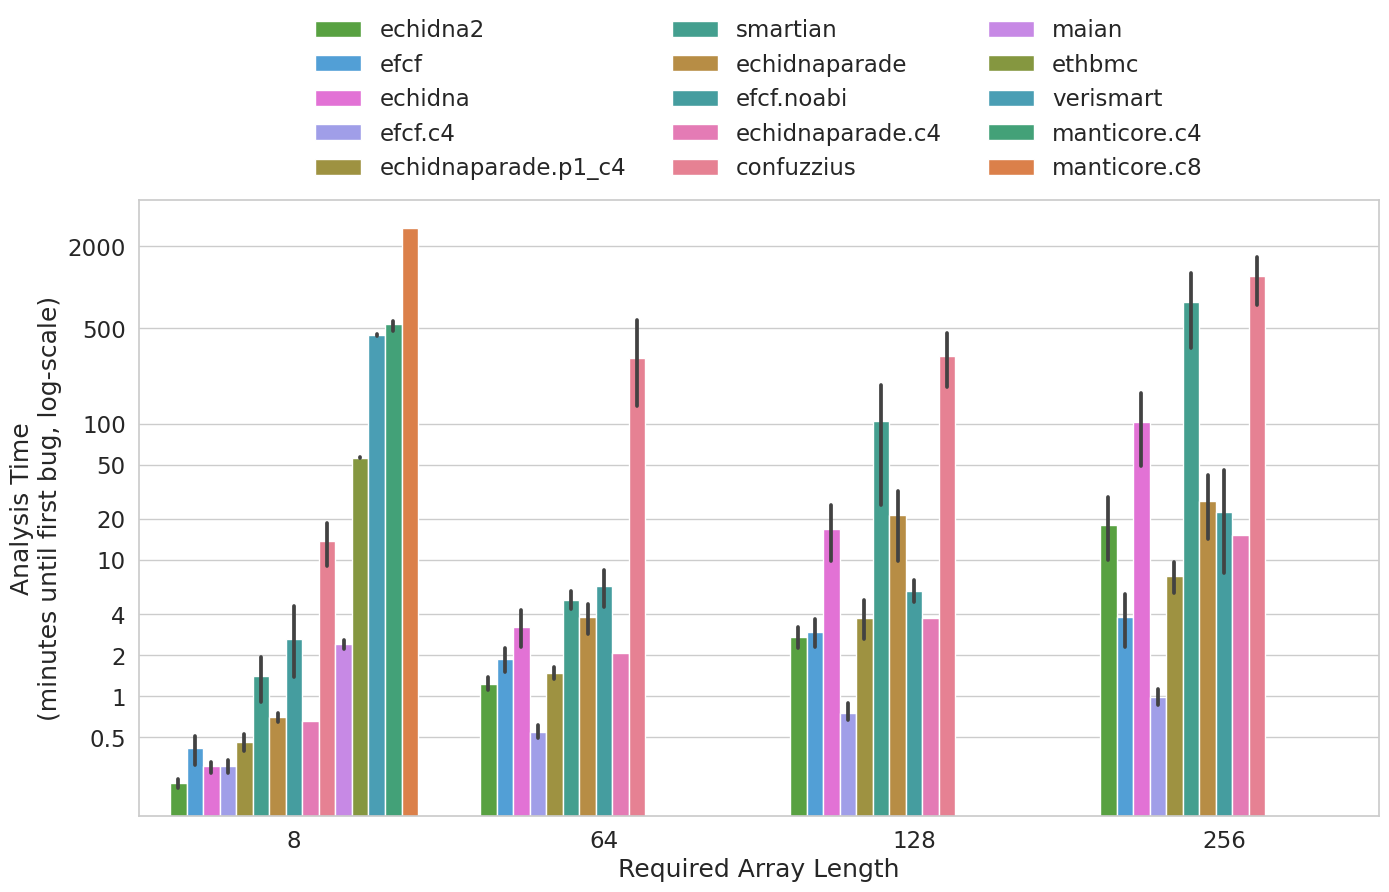

In [53]:
import random


def make_justlen_plot(tools, figsize=(7,5), combined=combined, last_tick=None, order=None, color=None, contract_type='justlen'):
    c = combined.copy()
    c['runtime'] = c['runtime'].apply(lambda x: x / 60)

    c.drop(c.index[c["contract"] != contract_type], inplace=True)
    
    c = c[c['bugfound']]
    if tools:
        c = c[c['tool'].isin(tools)]
    c = c.sort_values('runtime')
        
    sns.set_context("paper")
    sns.set(font_scale=1.5)
    if color:
        sns.set_palette(color)
    else:
        if len(tools) > 10:
            ch = list(sns.color_palette("husl", len(tools)))
            random.shuffle(ch)
            sns.set_palette(ch)
        else:
            sns.set_palette("Colorblind")
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=figsize)
    p = sns.barplot(data = c,
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime', 
                     ax=ax,
                     hue_order=order)

    ymax= math.ceil(c['runtime'].max())
    # ax.set_ylim((0, ymax))

    ax.set_yscale('log')
    ax.set_ylabel("Analysis Time\n(minutes until first bug, log-scale)")
    ax.set_xlabel("Required Array Length")

    ticks = [0.5,1,2,4,10,20,50,100,500,2000]
    if last_tick is not None:
        ticks = [tick for tick in ticks if tick <= last_tick]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )
    return fig, ax


c = combined.copy()
c.drop(c.index[c["contract"] != 'justlen'], inplace=True)
capable_tools = set()
for tool in set(c['tool']):
    if sum(c[c['tool'] == tool]['bugfound']) > 0:
        capable_tools.add(tool)

capable_tools.difference_update({'confuzziuspypy',
                                 'manticore.thorough', 
                                 'echidnaparade.p1'
                                })
        
fig, ax = make_justlen_plot(capable_tools, (16,8))


In [54]:
colors = sns.color_palette("colorblind")
colors.insert(1, colors.pop())
sns.color_palette(colors)

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2)]

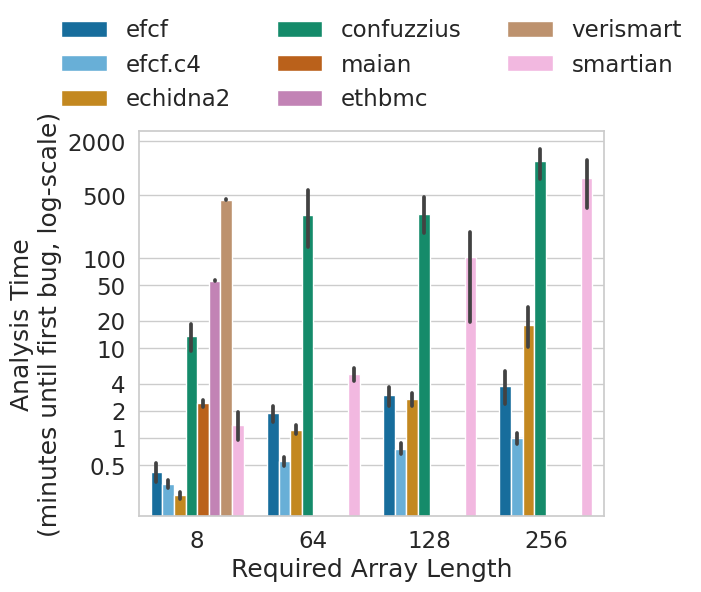

In [55]:
# colors = sns.color_palette("Paired")
# colors[2] = colors[7]

toolslist = ["efcf", 'efcf.c4', 'echidna2', 'confuzzius', 'maian', 'ethbmc', 'verismart', 'smartian']
tools = set(toolslist)

fig, ax = make_justlen_plot(tools, (6,5), order=toolslist, color=colors)


ax.get_figure().savefig("./justlen.v2.pdf", bbox_inches='tight')
ax.get_figure().savefig("./justlen.v2.png", bbox_inches='tight')
ax.get_figure().savefig("./justlen.v2.svg", bbox_inches='tight')

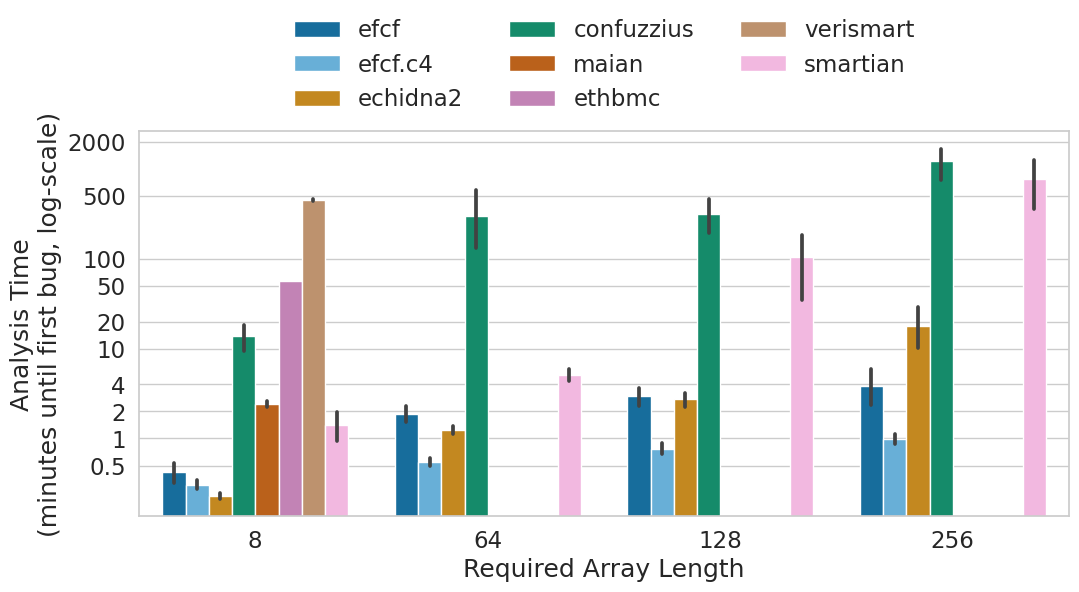

In [56]:
# colors = sns.color_palette("Paired")
# colors[2] = colors[7]

toolslist = ["efcf", 'efcf.c4', 'echidna2', 'confuzzius', 'maian', 'ethbmc', 'verismart', 'smartian']
tools = set(toolslist)

fig, ax = make_justlen_plot(tools, (12,5), order=toolslist, color=colors)

ax.get_figure().savefig("./justlen.v2.wide.pdf", bbox_inches='tight')

In [57]:
c['runtime'].max()

172800.0

In [58]:
c.loc[c['tool'] == 'efcf'].describe()

runtime   txlength
count   40.000000   40.00000
mean   136.825000  114.00000
std    119.904425   93.50168
min     11.000000    8.00000
25%     46.500000   50.00000
50%    119.500000   96.00000
75%    191.250000  160.00000
max    641.000000  256.00000

In [59]:
c.loc[c['tool'] == 'echidna2'].describe()

runtime   txlength
count    40.000000   40.00000
mean    333.276031  114.00000
std     647.202498   93.50168
min      10.492870    8.00000
25%      49.719673   50.00000
50%     104.891866   96.00000
75%     274.189331  160.00000
max    3600.512259  256.00000

## Multi Simple

In [60]:
# TODO: for some reason some of the EF/CF things are missing?

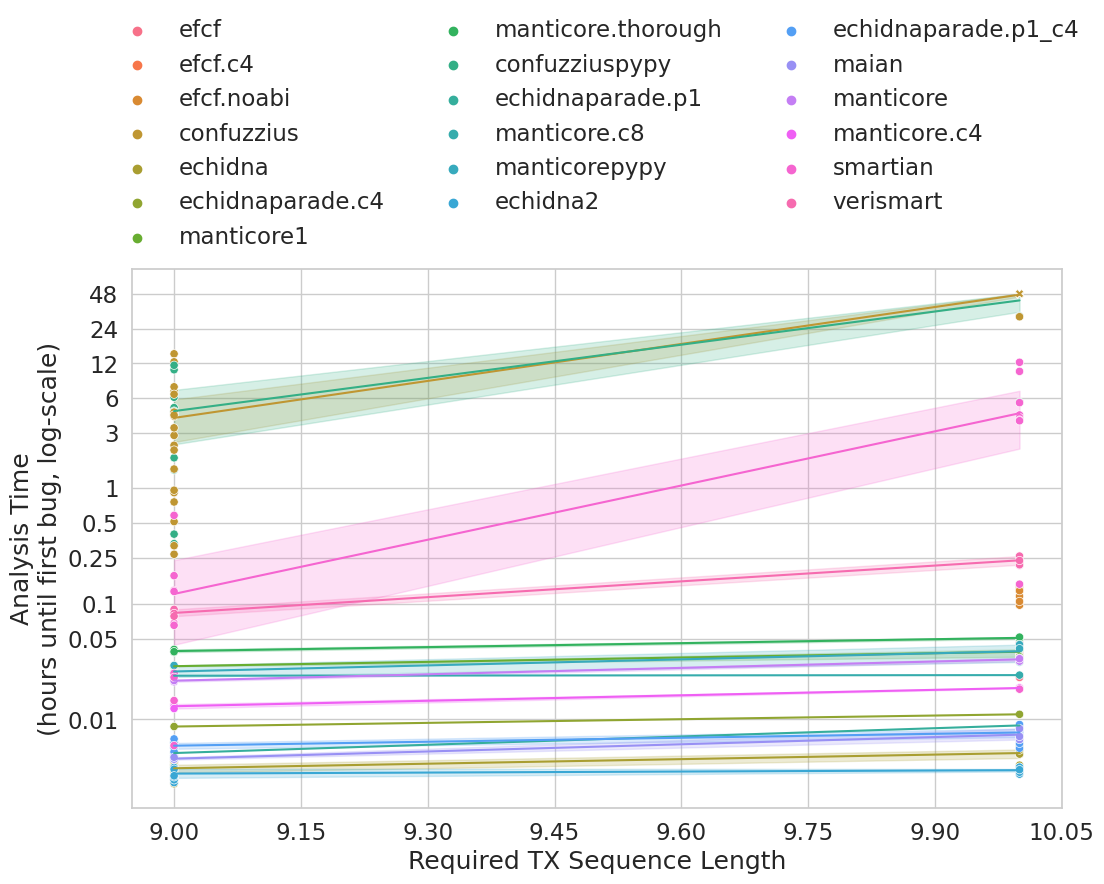

In [61]:
fig, ax = make_multi_gen_plot(None, contract_type='multi_simple')

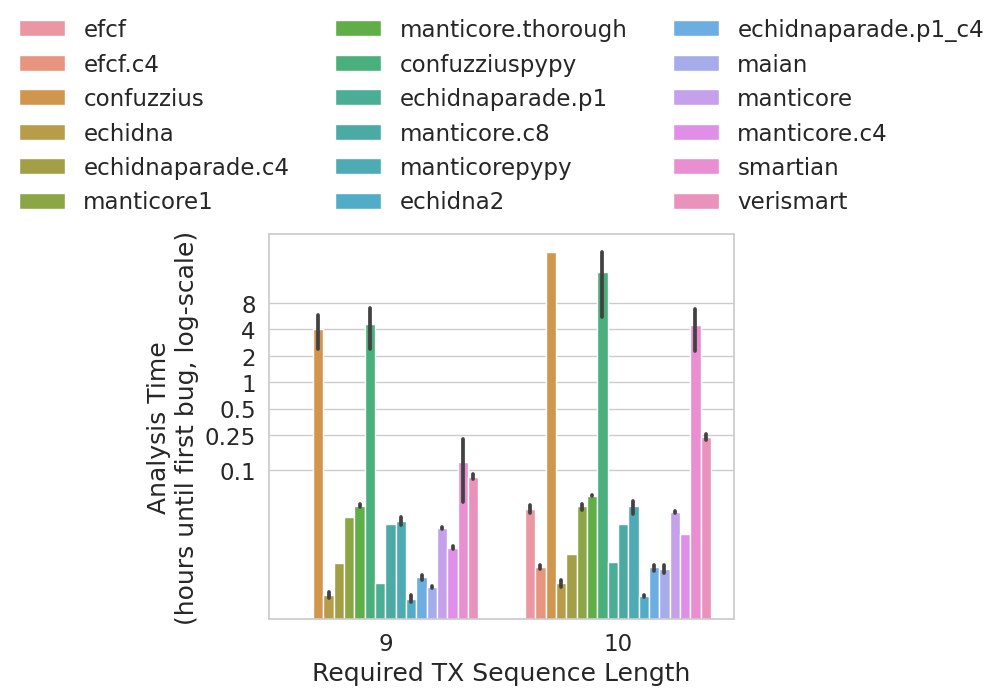

In [62]:
fig, ax = make_multi_complex_plot (None, contract_type='multi_simple')

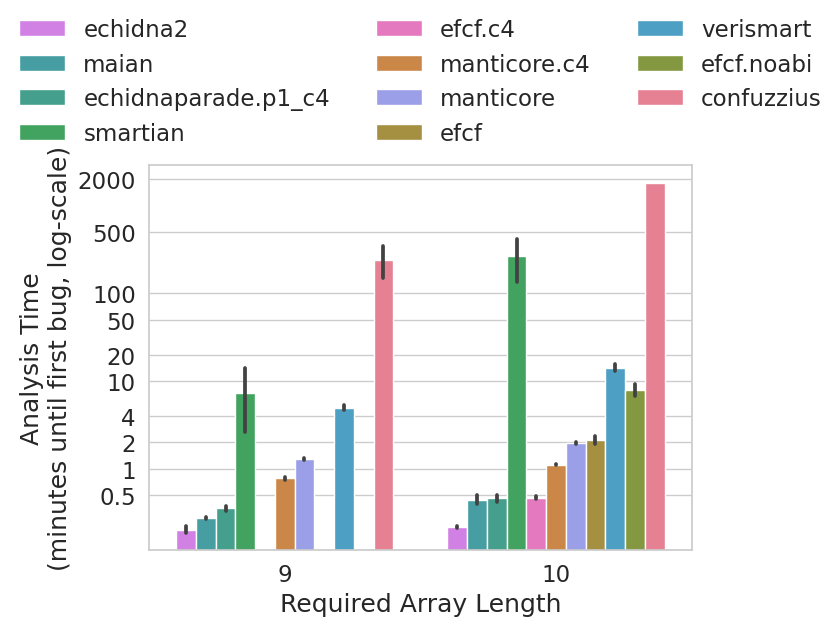

In [63]:
c = combined.copy()
c.drop(c.index[c["contract"] != 'multi_simple'], inplace=True)
capable_tools = set()
for tool in set(c['tool']):
    if sum(c[c['tool'] == tool]['bugfound']) > 0:
        capable_tools.add(tool)

capable_tools.difference_update({'confuzziuspypy',
                                 'manticore.thorough', 
                                 'echidnaparade.p1',
                                 'echidnaparade.c4',
                                 'manticore1',
                                 'manticorepypy',
                                 'manticore.c8',
                                 'echidna',
#                                  'manticore.c4',
#                                  'echidnaparade.p1_c4',
#                                  'efcf.c4',
                                })
        
fig, ax = make_justlen_plot(capable_tools, contract_type='multi_simple')

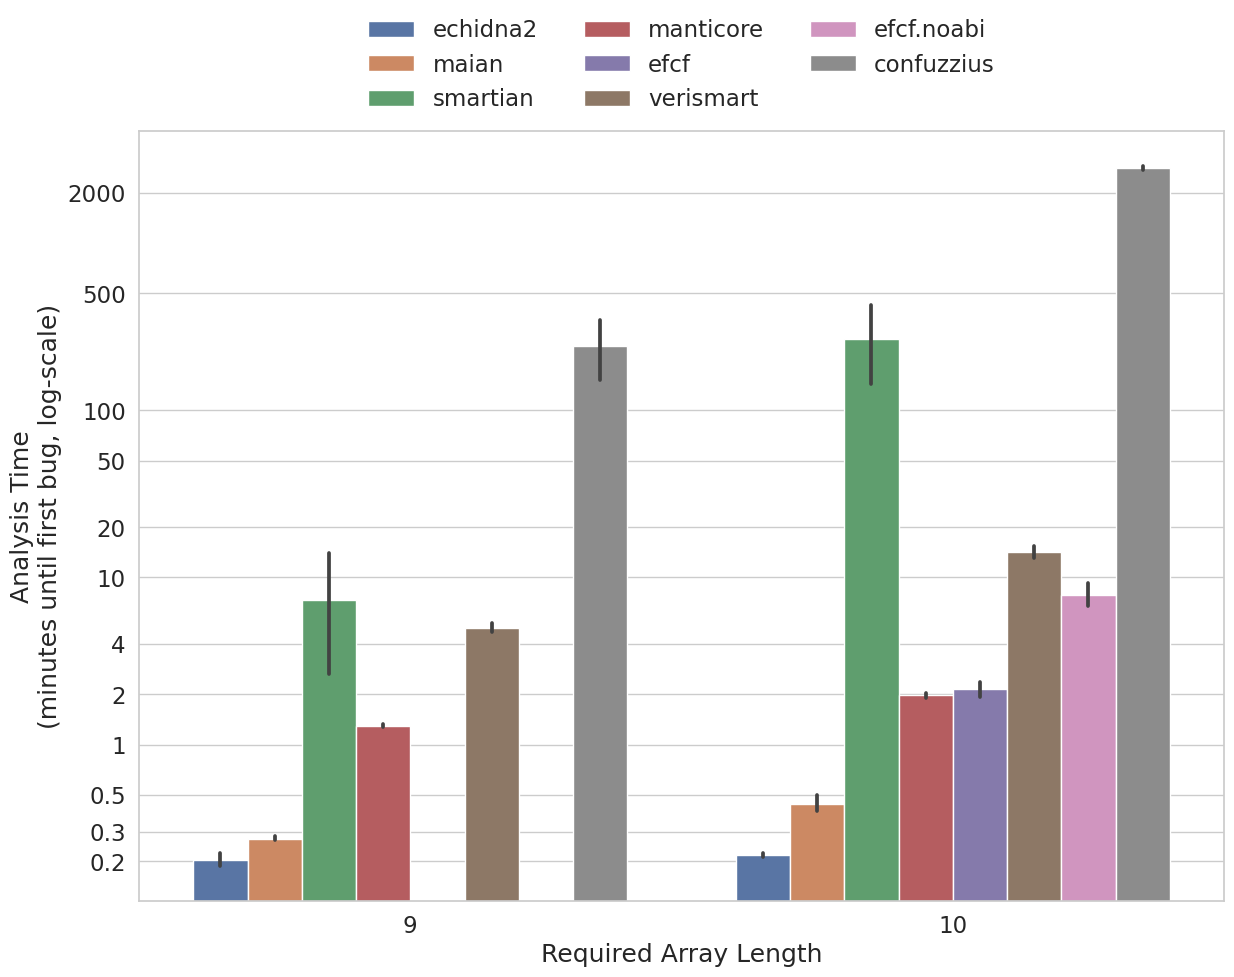

In [64]:
contract_type = 'multi_simple'
figsize=(14,10)
last_tick=None
order=None
color=None

c = combined.copy()
c.drop(c.index[c["contract"] != contract_type], inplace=True)
capable_tools = set()
for tool in set(c['tool']):
    if sum(c[c['tool'] == tool]['bugfound']) > 0:
        capable_tools.add(tool)

capable_tools.difference_update({'confuzziuspypy',
                                 'manticore.thorough', 
                                 'echidnaparade.p1',
                                 'echidnaparade.c4',
                                 'manticore1',
                                 'manticorepypy',
                                 'manticore.c8',
                                 'echidna',
                                 'manticore.c4',
                                 'echidnaparade.p1_c4',
                                 'efcf.c4',
                                })

tools = capable_tools

c['runtime'] = c['runtime'].apply(lambda x: x / 60)

c.drop(c.index[c["contract"] != contract_type], inplace=True)

# c = c[c['bugfound']]  # don't need since we only do capable tools
if tools:
    c = c[c['tool'].isin(tools)]
c = c.sort_values('runtime')

sns.set_context("paper")
sns.set(font_scale=1.5)
if color:
    sns.set_palette(color)
else:
    if len(tools) > 10:
        ch = list(sns.color_palette("husl", len(tools)))
        random.shuffle(ch)
        sns.set_palette(ch)
    else:
        pass
#         sns.set_palette("Colorblind")
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=figsize)
# for ax, col in zip(axs, tools):
#     sns.barplot(x="Group", y=col, units="subject", ci = 68, hue="Group", data=demo_masq, ax=ax)
p = sns.barplot(data = c,
                 hue = 'tool',
                 x = 'txlength',
                 y = 'runtime', 
                 ax=ax,
                 hue_order=order)

ymax= math.ceil(c['runtime'].max())
# ax.set_ylim((0, ymax))

ax.set_yscale('log')
ax.set_ylabel("Analysis Time\n(minutes until first bug, log-scale)")
ax.set_xlabel("Required Array Length")

ticks = [0.2, 0.3, 0.5,1,2,4,10,20,50,100,500,2000]
if last_tick is not None:
    ticks = [tick for tick in ticks if tick <= last_tick]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

[Text(0, 0.2, '0.2'),
 Text(0, 0.3, '0.3'),
 Text(0, 0.5, '0.5'),
 Text(0, 1.0, '1'),
 Text(0, 2.0, '2'),
 Text(0, 4.0, '4'),
 Text(0, 10.0, '10'),
 Text(0, 20.0, '20'),
 Text(0, 50.0, '50'),
 Text(0, 100.0, '100'),
 Text(0, 500.0, '500'),
 Text(0, 2000.0, '2000')]

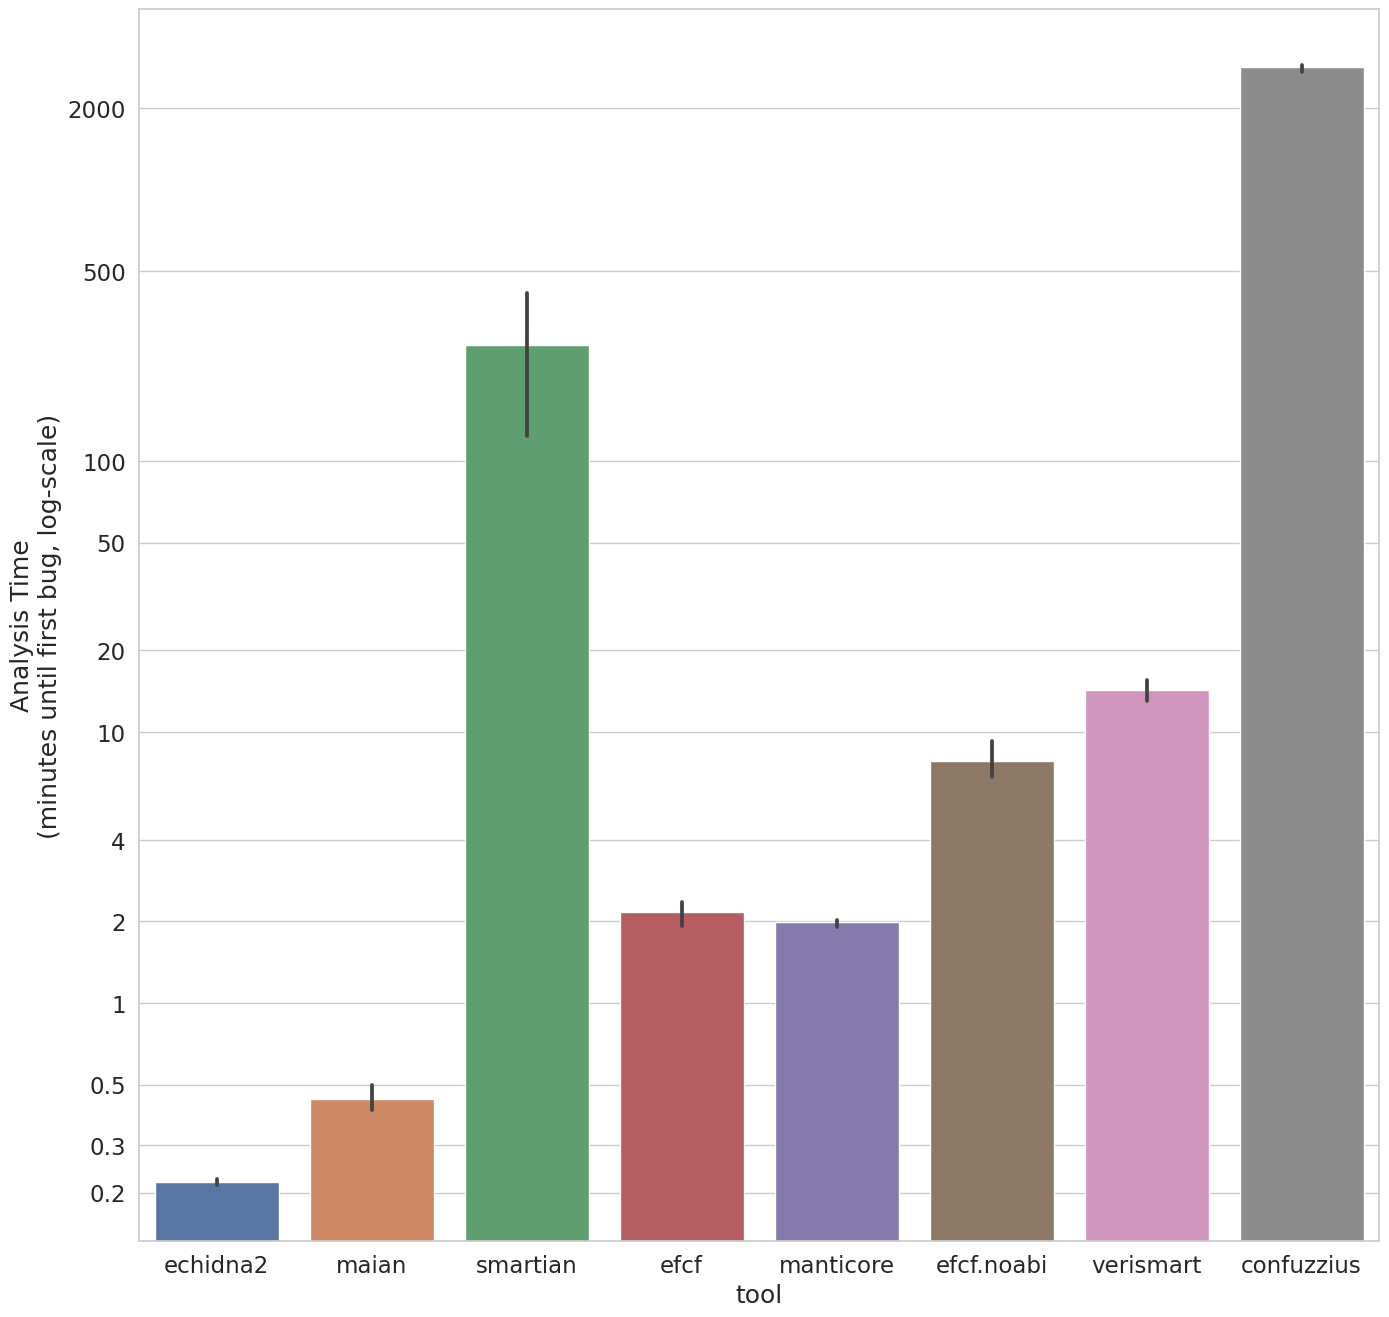

In [65]:
contract_type = 'multi_simple'
figsize=(14,10)
last_tick=None
order=None
color=None

c = combined.copy()
c.drop(c.index[c["contract"] != contract_type], inplace=True)
capable_tools = set()
for tool in set(c['tool']):
    if sum(c[c['tool'] == tool]['bugfound']) > 0:
        capable_tools.add(tool)

capable_tools.difference_update({'confuzziuspypy',
                                 'manticore.thorough', 
                                 'echidnaparade.p1',
                                 'echidnaparade.c4',
                                 'manticore1',
                                 'manticorepypy',
                                 'manticore.c8',
                                 'echidna',
                                 'manticore.c4',
                                 'echidnaparade.p1_c4',
                                 'efcf.c4',
                                })

tools = capable_tools

c['runtime'] = c['runtime'].apply(lambda x: x / 60)

c.drop(c.index[c["contract"] != contract_type], inplace=True)
c.drop(c.index[c["txlength"] != 10], inplace=True)

# c = c[c['bugfound']]  # don't need since we only do capable tools
if tools:
    c = c[c['tool'].isin(tools)]
c = c.sort_values('runtime')

sns.set_context("paper")
sns.set(font_scale=1.5)
if color:
    sns.set_palette(color)
else:
    if len(tools) > 10:
        ch = list(sns.color_palette("husl", len(tools)))
        random.shuffle(ch)
        sns.set_palette(ch)
    else:
        pass
#         sns.set_palette("Colorblind")
sns.set_style("whitegrid")

# fig, ax = plt.subplots()
# for ax, col in zip(axs, tools):
#     sns.barplot(x="Group", y=col, units="subject", ci = 68, hue="Group", data=demo_masq, ax=ax)
ax = sns.barplot(data = c,
                 x = 'tool',
                 y = 'runtime')

ymax= math.ceil(c['runtime'].max())
# ax.set_ylim((0, ymax))

ax.set_yscale('log')
ax.set_ylabel("Analysis Time\n(minutes until first bug, log-scale)")
# ax.set_xlabel("Required Array Length")

ticks = [0.2, 0.3, 0.5,1,2,4,10,20,50,100,500,2000]
if last_tick is not None:
    ticks = [tick for tick in ticks if tick <= last_tick]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks)

In [66]:
c[c['tool'] == 'efcf']['runtime'].describe()

count    10.000000
mean      2.163333
std       0.360024
min       1.383333
25%       2.045833
50%       2.175000
75%       2.354167
max       2.766667
Name: runtime, dtype: float64

In [67]:
c[c['tool'] == 'echidna2']['runtime'].describe()

count    10.000000
mean      0.218257
std       0.009435
min       0.201603
25%       0.211977
50%       0.218617
75%       0.222816
max       0.231942
Name: runtime, dtype: float64

In [68]:
c[c['tool'] == 'smartian']['runtime'].describe()

count     10.000000
mean     266.608184
std      246.952128
min        1.095299
25%       67.084294
50%      238.641541
75%      311.296303
max      735.631744
Name: runtime, dtype: float64

In [69]:
c[c['tool'] == 'confuzzius']['runtime'].describe()

count      20.000000
mean     2827.082611
std       236.653758
min      1821.652221
25%      2880.000000
50%      2880.000000
75%      2880.000000
max      2880.000000
Name: runtime, dtype: float64

# Ablation Study Multi Analysis

In [70]:
def assign_tool(mode):
    d = {'2AT': "Full", "noabi": "Full w/o ABI", "aonly": "AFL", "monly": "EM"}
    return d[mode]

abl_order = ["AFL", "EM", "Full", "Full w/o ABI"]

multi_abl = pd.read_csv("./fuzz-multi-modes.csv")

multi_abl[WALLCLOCK] = multi_abl[WALLCLOCK].map(sanitize_wallclocktime)
multi_abl[WALLCLOCK] = pd.to_timedelta(multi_abl[WALLCLOCK])
multi_abl['runtime'] = multi_abl[WALLCLOCK].map(lambda x: x.total_seconds())
multi_abl['txlength'] = multi_abl['contract'].map(lambda x: int(x.split('_')[-1] if '_' in x else x.strip("justlen")))
multi_abl.rename(columns={"contract": "contractname"}, inplace=True)
multi_abl['contract'] = multi_abl['contractname'].map(lambda x: "justlen" if "justlen" in x else "_".join((x.split('_')[:-1])))
multi_abl['mode'] = multi_abl['mode'].map(lambda x: x.replace("mode-", "").strip())
multi_abl['tool'] = multi_abl['mode'].map(assign_tool)
#multi_abl

In [71]:
cols = ['tool', 'runtime', 'contract', 'txlength', 'bugfound']
abl_comb = pd.DataFrame(multi_abl[['tool', 'runtime', 'contract', 'txlength', 'total_crashes']])
abl_comb.rename(columns={'total_crashes': 'bugfound'}, inplace=True)

MAX_RUNTIME = 8 * 60 * 60
abl_comb['runtime'] = abl_comb['runtime'].apply(lambda x: MAX_RUNTIME if x > MAX_RUNTIME else x)
# abl_comb['runtime'] = abl_comb['runtime'].apply(lambda x: x / 60 / 60)
def sanit_bugfound(x):
    if isinstance(x, int):
        return x > 0
    else:
        return x != "None"
abl_comb['bugfound'] = abl_comb['bugfound'].apply(sanit_bugfound)
#abl_comb

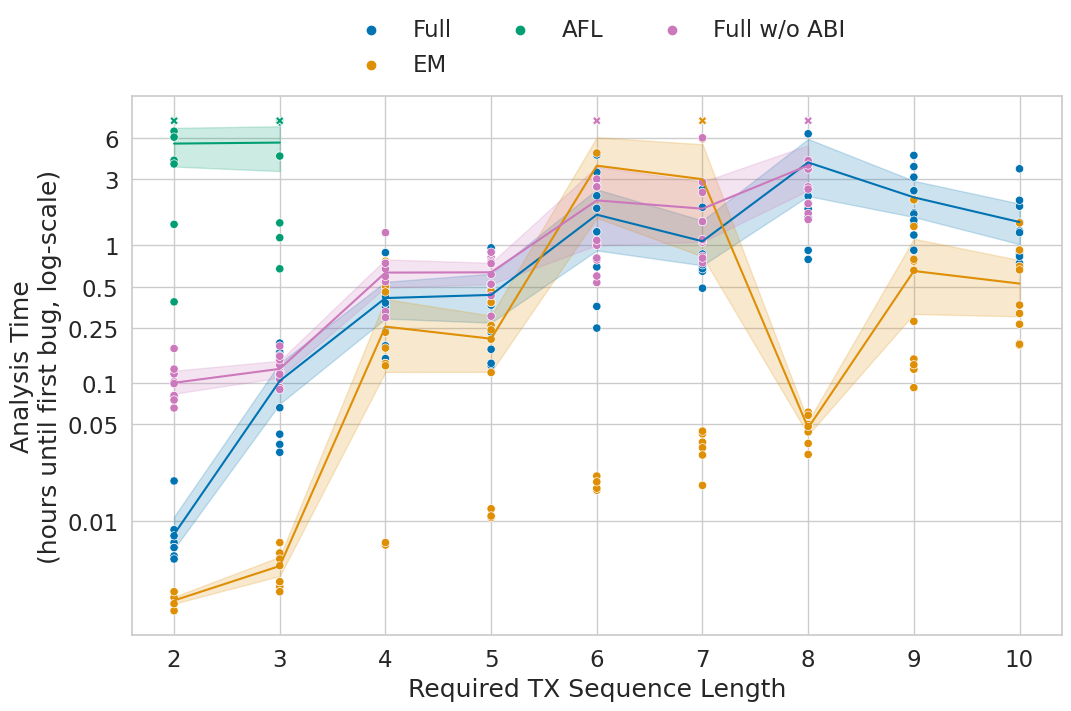

In [72]:
colors = sns.color_palette("colorblind")
x = colors[3], colors[4]
colors[4], colors[3] = x
sns.color_palette(colors)

fig, ax = make_multi_gen_plot(None, combined=abl_comb, last_tick=8, colors=colors)
ax.get_figure().savefig("./multi_ablation_lineplot.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_ablation_lineplot.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_ablation_lineplot.svg", bbox_inches='tight')

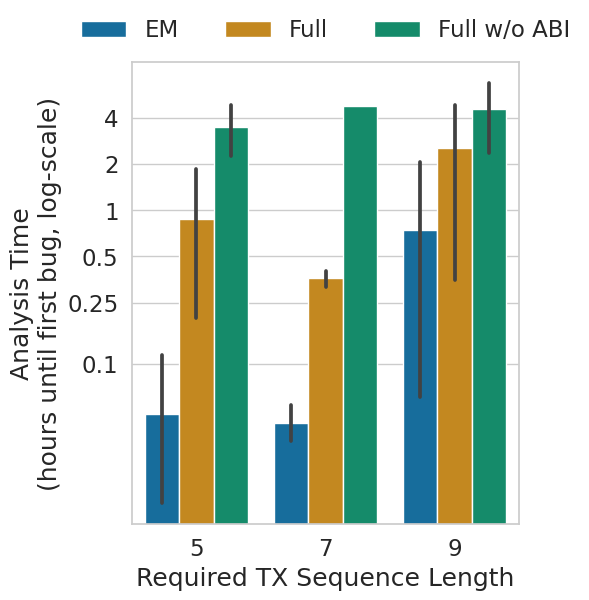

In [73]:
def make_abl_multi_plot(figsize=(5,6)):
    c = abl_comb.copy()

    c.drop(c.index[c["contract"] != 'multi_man_complex'], inplace=True)
    c['runtime'] = c['runtime'].apply(lambda x: x / 60 / 60)
    c = c[c['bugfound'] == True]

    sns.set_context("paper")
    sns.set(font_scale=1.5)
    sns.set_palette("colorblind")
    sns.set_style("whitegrid")

    fig, ax = plt.subplots(figsize=figsize)

    b = sns.barplot(data = c,
                     hue = 'tool',
                     x = 'txlength',
                     y = 'runtime',
                   ax=ax, hue_order=abl_order[1:])

    ax.set_yscale('log')
    # fig.ax.set(ylim=(0,48))
    ticks = [0.1, 0.25, 0.5, 1, 2,4,] #10,24,48]
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks)

    ax.set_ylabel("Analysis Time\n(hours until first bug, log-scale)")
    ax.set_xlabel("Required TX Sequence Length")
    # fig.ax.set(xlim=(2,10))

    sns.move_legend(
        ax, "lower center",
        bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
    )

    return (fig, ax)

fig, ax = make_abl_multi_plot()
ax.get_figure().savefig("./multi_man_ablation.pdf", bbox_inches='tight')
ax.get_figure().savefig("./multi_man_ablation.png", bbox_inches='tight')
ax.get_figure().savefig("./multi_man_ablation.svg", bbox_inches='tight')

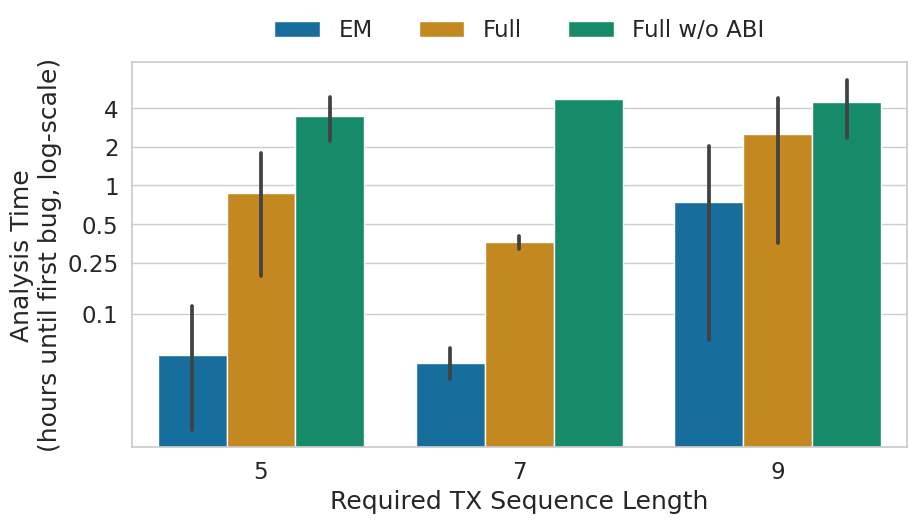

In [74]:
fig, ax = make_abl_multi_plot(figsize=(10,5))
ax.get_figure().savefig("./multi_man_ablation.wide.pdf", bbox_inches='tight')

In [75]:
c = multi_abl[multi_abl['contract'].isin({'multi_gen', 'multi_man_complex'})]
q = c[c['mode'].isin({'noabi', '2AT'})]
#q

In [76]:
q[q['mode'] == '2AT']['time'].map(lambda x: x / 60).describe()

count    120.000000
mean      86.609583
std      127.227961
min        0.183333
25%       13.591667
50%       30.050000
75%       97.395833
max      480.000000
Name: time, dtype: float64

In [77]:
q[q['mode'] == 'noabi']['time'].map(lambda x: x / 60).describe()

count    120.000000
mean     223.008056
std      205.360262
min        3.816667
25%       35.466667
50%      143.266667
75%      480.000000
max      480.000000
Name: time, dtype: float64

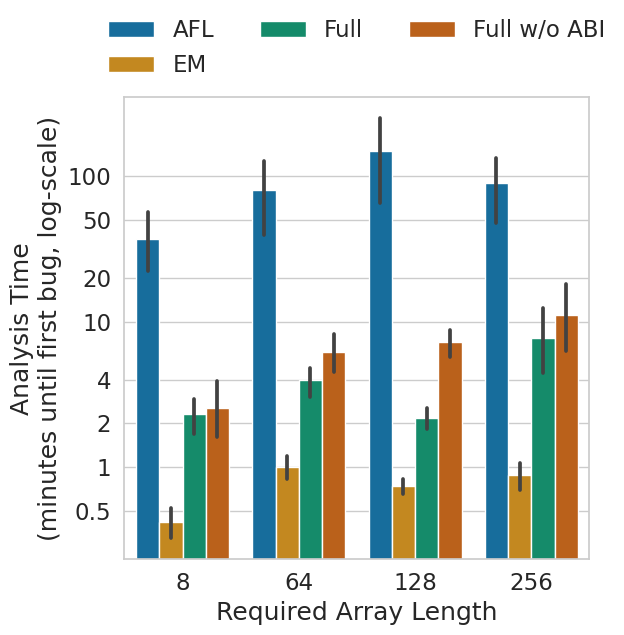

In [78]:
fig, ax = make_justlen_plot(None, figsize=(6,6), 
                            combined=abl_comb, 
                            last_tick=200, 
                            color="colorblind",
                            order=abl_order)
ax.get_figure().savefig("./justlen_ablation.pdf", bbox_inches='tight')
ax.get_figure().savefig("./justlen_ablation.png", bbox_inches='tight')
ax.get_figure().savefig("./justlen_ablation.svg", bbox_inches='tight')

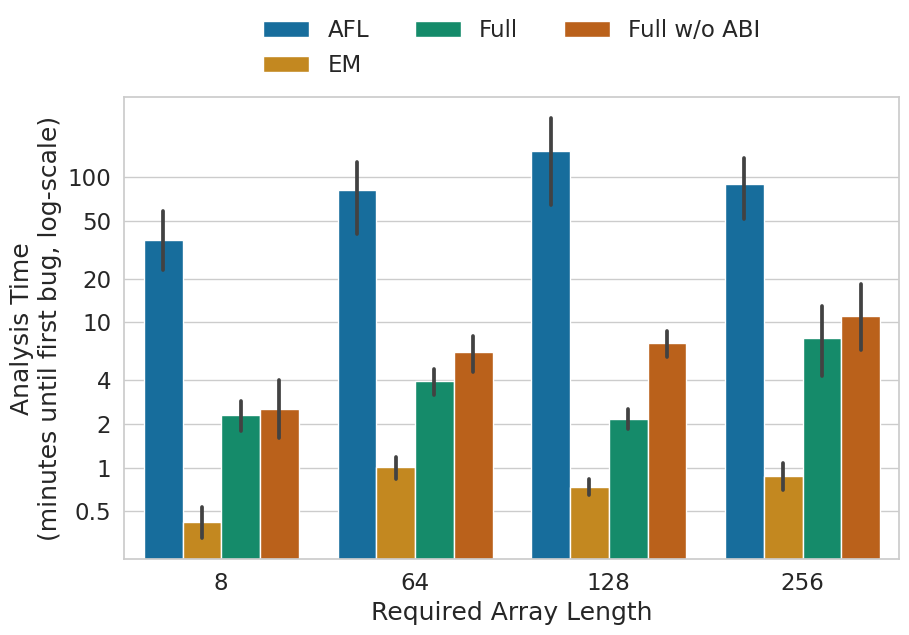

In [79]:
fig, ax = make_justlen_plot(None, figsize=(10,6), 
                            combined=abl_comb, 
                            last_tick=200, 
                            color="colorblind",
                            order=abl_order)
ax.get_figure().savefig("./justlen_ablation.wide.pdf", bbox_inches='tight')

In [80]:
c = multi_abl[multi_abl['contract'].isin({'justlen'})]
q = c[c['mode'].isin({'noabi', '2AT'})]
#q

In [81]:
q[q['mode'] == '2AT']['time'].map(lambda x: x / 60).describe()

count    40.000000
mean      3.892500
std       4.215093
min       0.783333
25%       1.995833
50%       2.783333
75%       4.404167
max      25.233333
Name: time, dtype: float64

In [82]:
q[q['mode'] == 'noabi']['time'].map(lambda x: x / 60).describe()

count    40.000000
mean      6.608333
std       6.306518
min       0.600000
25%       2.766667
50%       4.666667
75%       8.279167
max      38.700000
Name: time, dtype: float64